# Extracting Rules with XAI from RAPP predictions

## Dropout when no exams in last three semesters

In [1]:
import pandas as pd
import numpy as np

from rapp import data

In [2]:
data.connect("data/rapp.db")

In [3]:
sql = "sql/cs_first_term_dropout.sql"
df = data.query_sql_file(sql, data.db_conn)

df

,Geburtsjahr,Geschlecht,Deutsch,AlterEinschreibung,KlausurenGeschrieben,KlausurenBestanden,Ects,DurchschnittsNote,StdevNoteQuadriert,Dropout
0,1976,männlich,1,21,5,4,44.0,1.712500,0.172969,0
1,1984,männlich,1,20,5,5,30.0,3.675000,0.049500,1
2,1981,männlich,1,23,1,1,10.0,2.700000,0.000000,1
3,1985,männlich,1,20,14,14,140.0,1.962500,0.404196,1
4,1983,männlich,1,22,7,7,70.0,2.766667,0.703810,0
...,...,...,...,...,...,...,...,...,...,...
1003,1988,weiblich,1,31,6,6,43.0,1.333333,0.082222,1
1004,1994,männlich,1,25,1,1,5.0,3.300000,0.000000,1
1005,1994,männlich,1,25,1,0,0.0,5.000000,0.000000,1
1006,1986,weiblich,1,33,1,0,0.0,5.000000,0.000000,1


In [4]:
def print_metric(cols, df):
    rows = len(df)
    for col in cols:
        count = len(df[df[col]==1])
        print(f"{col}:", count, f"({count*100./rows} %)")

In [5]:
print_metric(["Dropout"], df)

Dropout: 756 (75.0 %)


In [6]:
df_classification = df.copy(deep=True)
df_classification["StdevNote"] = np.sqrt(df["StdevNoteQuadriert"])
df_classification = df_classification.drop(["StdevNoteQuadriert"], axis=1)

In [7]:
df_classification.head()

,Geburtsjahr,Geschlecht,Deutsch,AlterEinschreibung,KlausurenGeschrieben,KlausurenBestanden,Ects,DurchschnittsNote,Dropout,StdevNote
0,1976,männlich,1,21,5,4,44.0,1.712500,0,0.415895
1,1984,männlich,1,20,5,5,30.0,3.675000,1,0.222486
2,1981,männlich,1,23,1,1,10.0,2.700000,1,0.000000
3,1985,männlich,1,20,14,14,140.0,1.962500,1,0.635764
4,1983,männlich,1,22,7,7,70.0,2.766667,0,0.838934


We need to one-hot encode the gender.

In [8]:
df_classification["Männlich"] = 1*(df_classification["Geschlecht"] == "männlich")
df_classification["Weiblich"] = 1*(df_classification["Geschlecht"] == "weiblich")
df_classification["Divers"] = 1*(df_classification["Geschlecht"] == "divers")

df_classification = df_classification.drop(["Geschlecht", "Geburtsjahr"], axis=1)

In [9]:
df_classification.head()

,Deutsch,AlterEinschreibung,KlausurenGeschrieben,KlausurenBestanden,Ects,DurchschnittsNote,Dropout,StdevNote,Männlich,Weiblich,Divers
0,1,21,5,4,44.0,1.712500,0,0.415895,1,0,0
1,1,20,5,5,30.0,3.675000,1,0.222486,1,0,0
2,1,23,1,1,10.0,2.700000,1,0.000000,1,0,0
3,1,20,14,14,140.0,1.962500,1,0.635764,1,0,0
4,1,22,7,7,70.0,2.766667,0,0.838934,1,0,0


### Prepare train and test set

In [10]:
X = df_classification.drop(["Dropout"], axis=1)
y = df_classification["Dropout"]

feature_names = X.columns

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=12)

### Train classifier

In [12]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

In [13]:
clf = DecisionTreeClassifier(class_weight="balanced", min_impurity_decrease=0.001)

In [14]:
clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', min_impurity_decrease=0.001)

In [15]:
def eval_model(clf, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test):
    y_pred = clf.predict(X_train)
    bacc = balanced_accuracy_score(y_train, y_pred)
    area = roc_auc_score(y_train, y_pred)
    conf = confusion_matrix(y_train, y_pred)
    print("# Trainset")
    print(f"Balanced accuracy: {bacc}")
    print(f"Area under curve: {area}")
    print(f"Confusion Matrix (tn, fp, fn, tp):")
    print(conf)

    y_pred = clf.predict(X_test)
    bacc = balanced_accuracy_score(y_test, y_pred)
    area = roc_auc_score(y_test, y_pred)
    conf = confusion_matrix(y_test, y_pred)
    print("# Testset")
    print(f"Balanced accuracy: {bacc}")
    print(f"Area under curve: {area}")
    print(f"Confusion Matrix (tn, fp, fn, tp):")
    print(conf)


In [16]:
eval_model(clf)

# Trainset
Balanced accuracy: 0.8595588583329389
Area under curve: 0.8595588583329389
Confusion Matrix (tn, fp, fn, tp):
[[169  16]
 [111 460]]
# Testset
Balanced accuracy: 0.6735377168212989
Area under curve: 0.6735377168212989
Confusion Matrix (tn, fp, fn, tp):
[[ 41  26]
 [ 49 136]]


### Display rules learned

In [17]:
%matplotlib inline
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [60, 20]

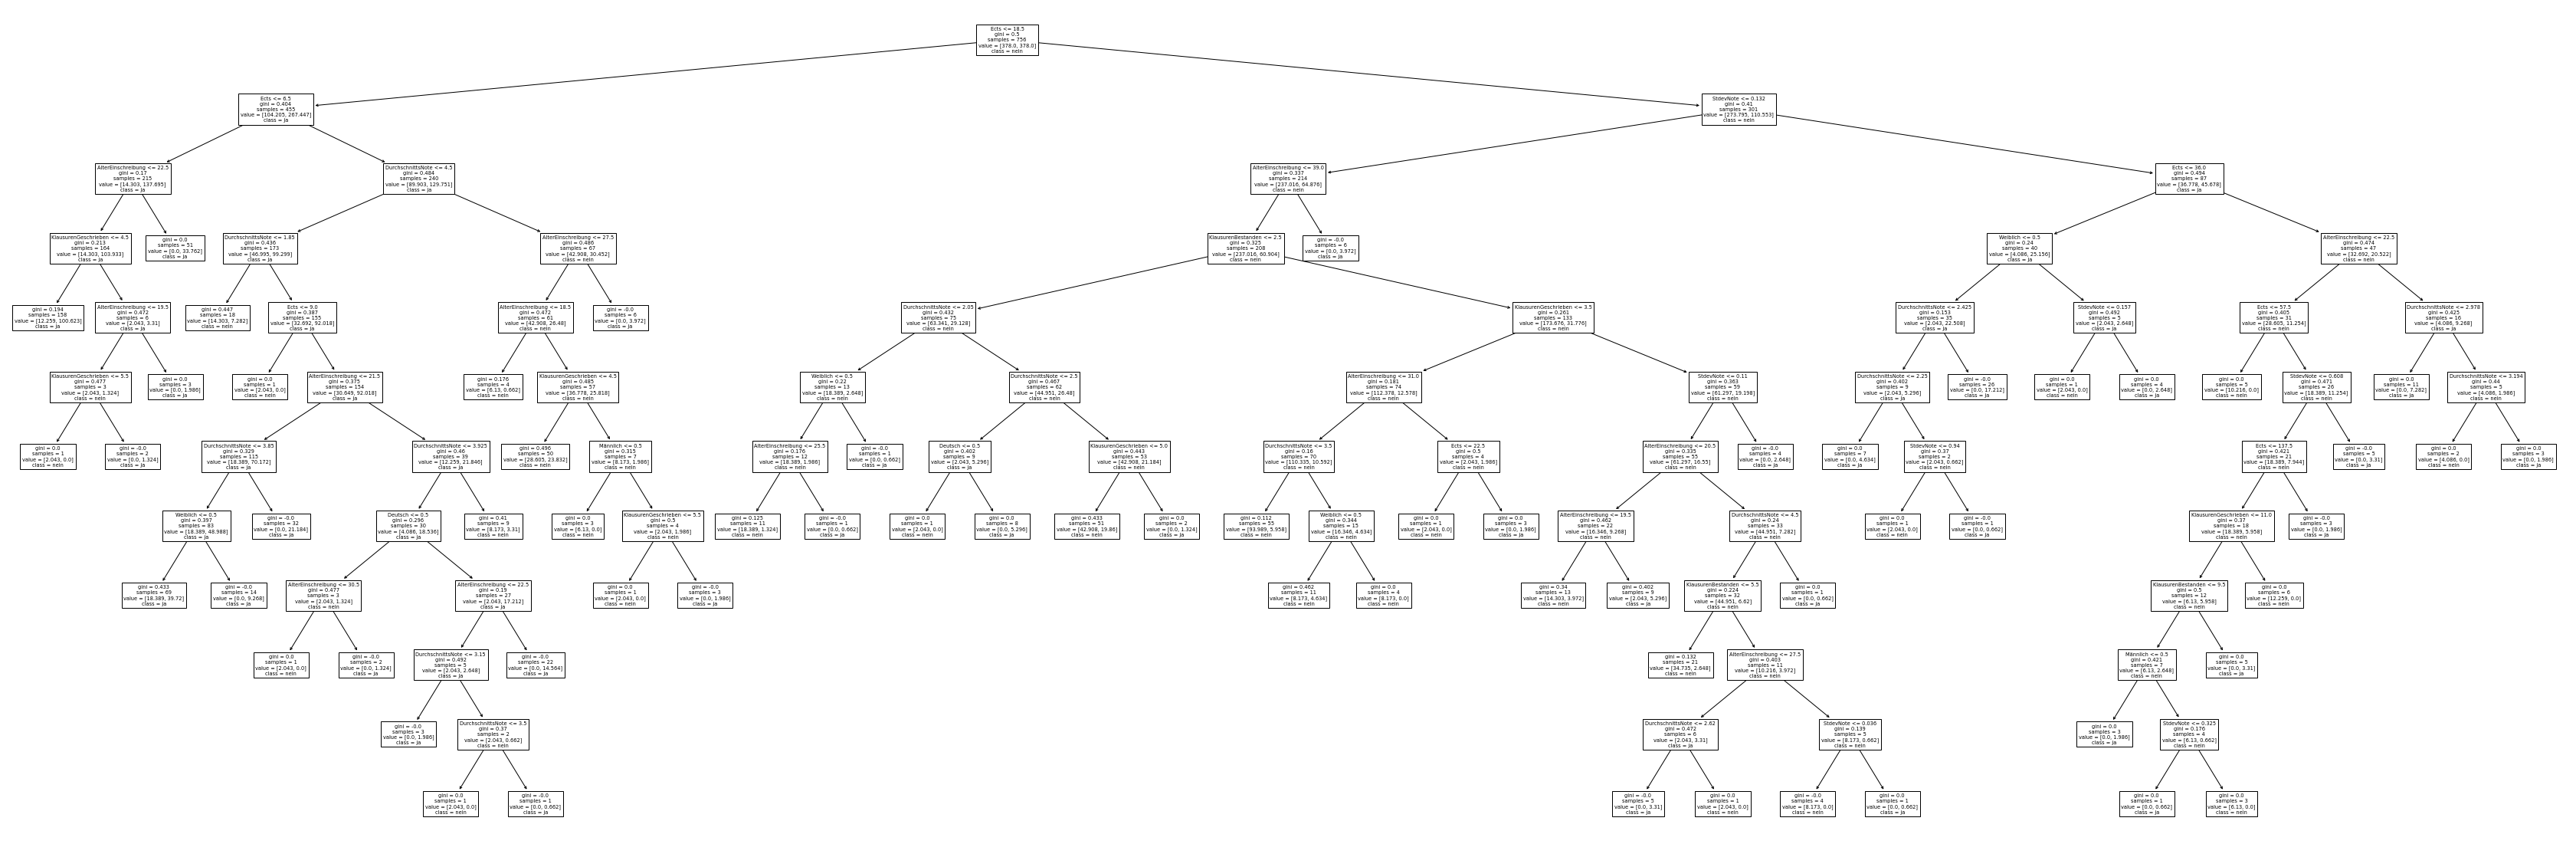

In [18]:
plot_tree(clf, feature_names = feature_names, class_names=["nein", "ja"])
plt.show()

(Right click image -> open in new tab to get a zoomable version.)

### Post pruning of the decision tree

As the decision tree above grew notably large and complex, we want to prune it to achieve a smaller yet comparably performant model. This will also battle the overfitting we observe (higher performances on training than test set).

This cost complexity pruning approach follows the example from https://ranvir.xyz/blog/practical-approach-to-tree-pruning-using-sklearn/ closely.

In [19]:
path = clf.cost_complexity_pruning_path(X_train, y_train)
path

{'ccp_alphas': array([0.        , 0.00132275, 0.00132275, 0.0013418 , 0.00142805,
        0.00146051, 0.00160299, 0.00162009, 0.00172835, 0.00178071,
        0.0018164 , 0.00183628, 0.00201307, 0.0021124 , 0.00211769,
        0.00217225, 0.00217944, 0.00244598, 0.00288577, 0.00304733,
        0.00310093, 0.00317604, 0.0033306 , 0.00334151, 0.00334523,
        0.00339236, 0.00353565, 0.00380059, 0.00396703, 0.00433705,
        0.00448446, 0.00656327, 0.00780738, 0.00898583, 0.01124568,
        0.01969835, 0.02361052, 0.09327566]),
 'impurities': array([0.19759759, 0.19892035, 0.2002431 , 0.20561031, 0.20846642,
        0.21138743, 0.21299042, 0.21461051, 0.21633886, 0.21811957,
        0.22175237, 0.22909748, 0.23312362, 0.24157324, 0.24369093,
        0.24803543, 0.25239431, 0.25728628, 0.26305782, 0.27219982,
        0.27530075, 0.27847679, 0.28513798, 0.29182099, 0.29851145,
        0.30868854, 0.31222419, 0.31602478, 0.31999181, 0.32432886,
        0.32881331, 0.33537658, 0.34318396

Text(0, 0.5, 'total impurity of leaves')

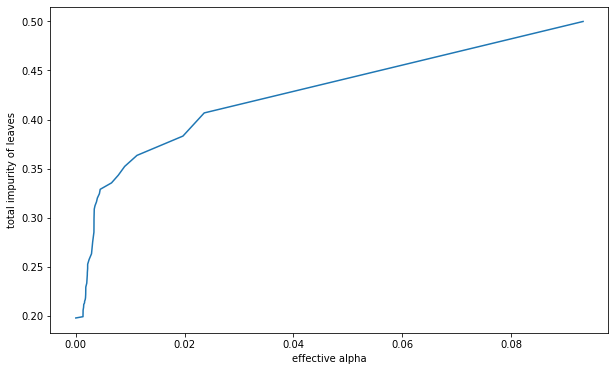

In [20]:
ccp_alphas, impurities = path.ccp_alphas, path.impurities

plt.figure(figsize=(10, 6))
plt.plot(ccp_alphas, impurities)
plt.xlabel("effective alpha")
plt.ylabel("total impurity of leaves")

In [21]:
clfs = []

for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha,
                                 class_weight="balanced", min_impurity_decrease=0.001)
    clf.fit(X_train, y_train)
    clfs.append(clf)

Text(0, 0.5, 'total depth')

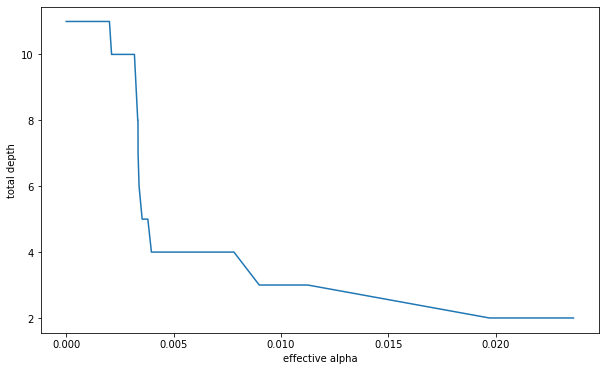

In [22]:
tree_depths = [clf.tree_.max_depth for clf in clfs]
plt.figure(figsize=(10,  6))
plt.plot(ccp_alphas[:-1], tree_depths[:-1])
plt.xlabel("effective alpha")
plt.ylabel("total depth")


Text(0, 0.5, 'Balanced Accuracy scores')

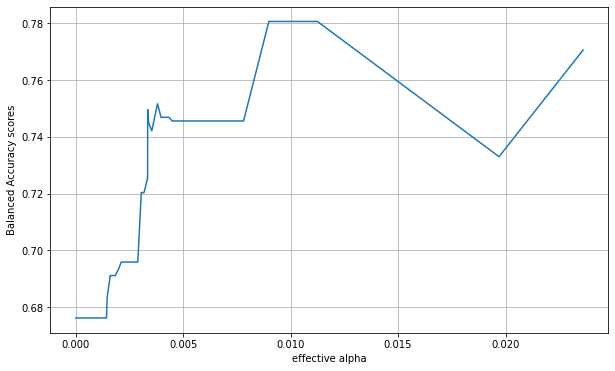

In [23]:
acc_scores = [balanced_accuracy_score(y_test, clf.predict(X_test)) for clf in clfs]

plt.figure(figsize=(10,  6))
plt.grid()
plt.plot(ccp_alphas[:-1], acc_scores[:-1])
plt.xlabel("effective alpha")
plt.ylabel("Balanced Accuracy scores")

In [24]:
selected_ccp = 0.009

In [25]:
clf = DecisionTreeClassifier(random_state=0, class_weight="balanced", min_impurity_decrease=0.001,
                             ccp_alpha=selected_ccp)
clf.fit(X_train, y_train)

eval_model(clf)

# Trainset
Balanced accuracy: 0.7437970369669145
Area under curve: 0.7437970369669143
Confusion Matrix (tn, fp, fn, tp):
[[132  53]
 [129 442]]
# Testset
Balanced accuracy: 0.7805970149253731
Area under curve: 0.7805970149253731
Confusion Matrix (tn, fp, fn, tp):
[[ 51  16]
 [ 37 148]]


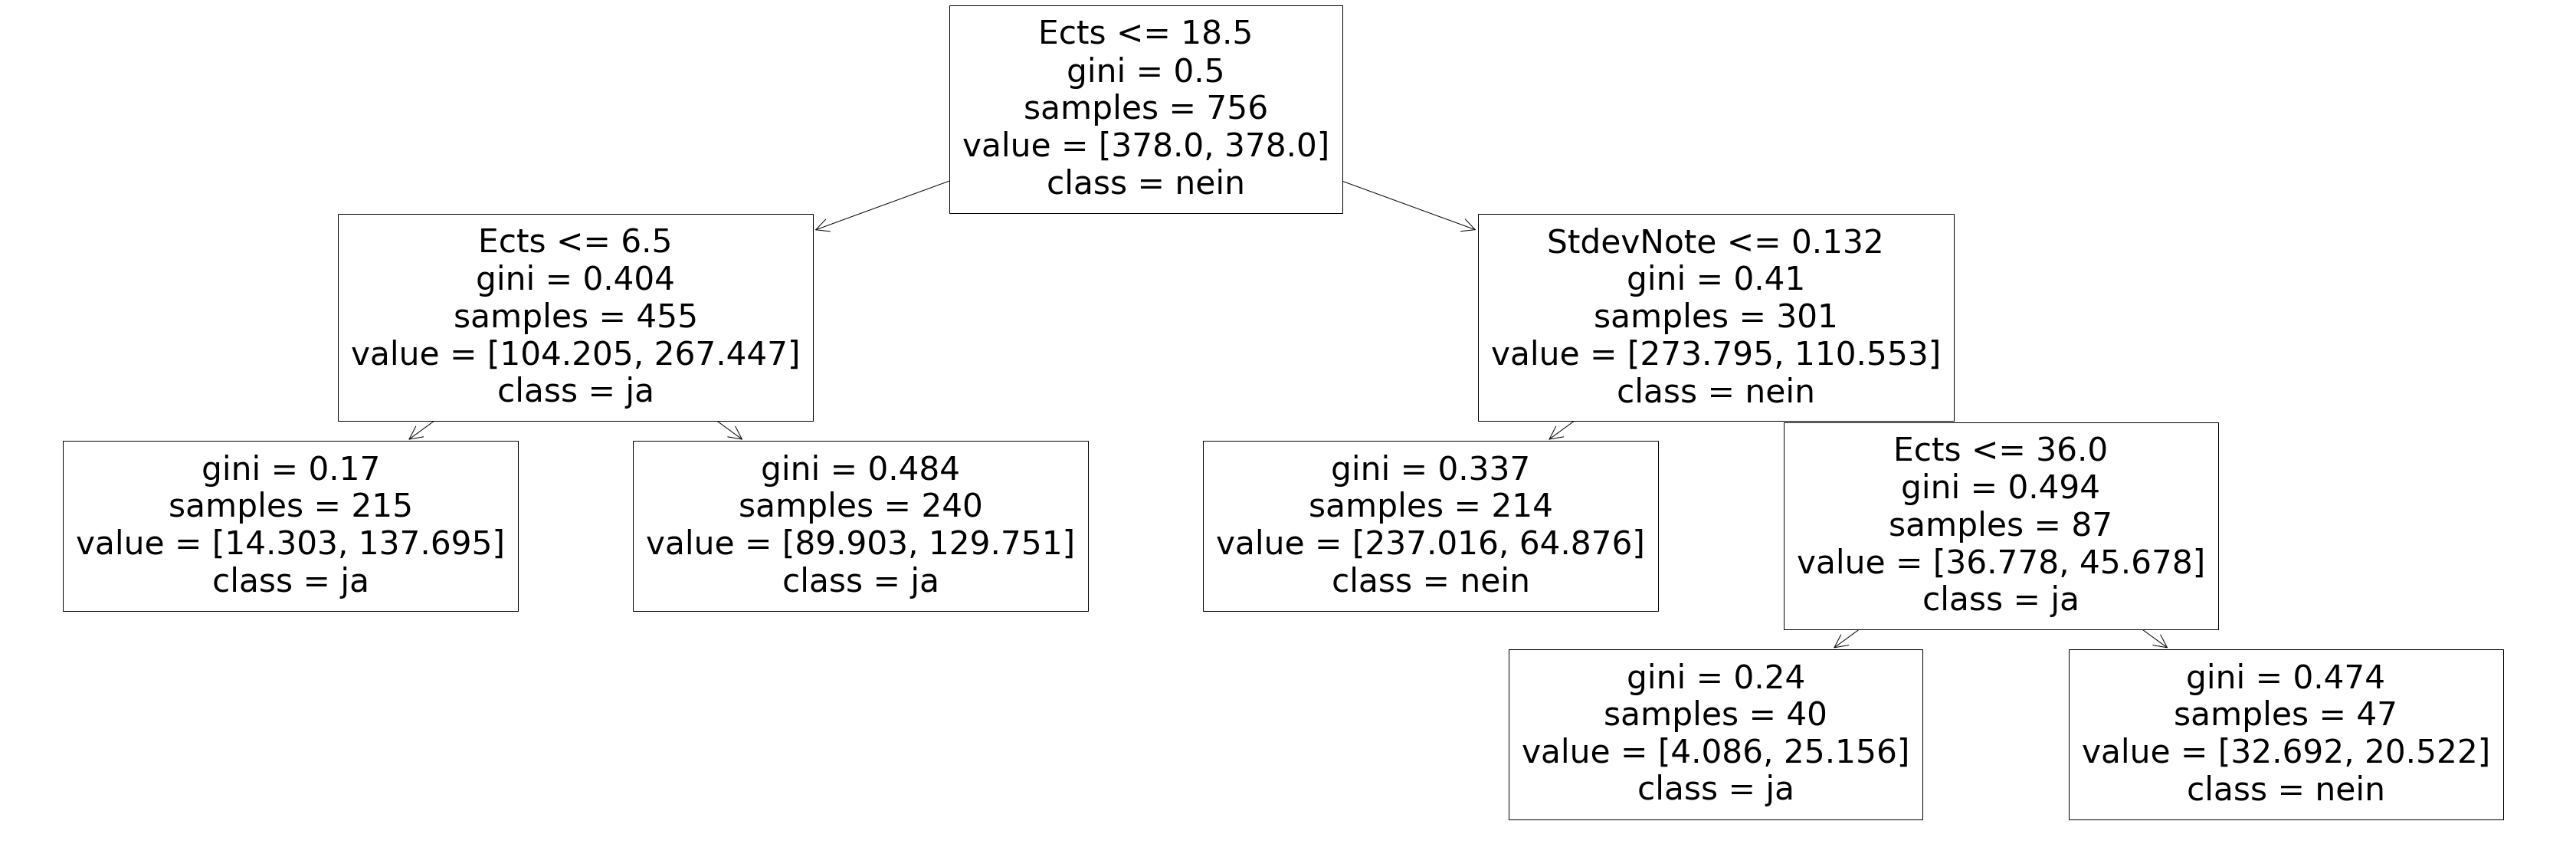

In [26]:
plot_tree(clf, feature_names = feature_names, class_names=["nein", "ja"])
plt.show()

## Alternative Data: Specific modules

The above approach only accounted for ECTS in first semester. As we can see there are some weird edge cases going on:

* Students with more than 36 ECTS
* Focus on standard deviation of the grade

In the following, we will look at some slightly altered version in which we do not investigate the accumulated ECTS as much as the individual modules a computing student would take in their first semester:

* software development and programming
* calculus I
* algorithms and data structures

In [27]:
sql = "sql/cs_first_three_module_dropout.sql"
df = data.query_sql_file(sql, data.db_conn)

df

,Geburtsjahr,Geschlecht,Deutsch,AlterEinschreibung,LABestanden,LAVersuche,ProgBestanden,ProgVersuche,ProgNote,AlgoBestanden,AlgoVersuche,AlgoNote,Dropout
0,1972,männlich,1,35,1,1,0,0,5.0,0,0,5.0,0
1,1987,weiblich,1,20,1,1,1,1,3.7,1,1,3.0,0
2,1988,männlich,1,19,1,2,1,1,3.3,0,0,5.0,0
3,1989,weiblich,1,18,1,1,0,0,5.0,1,1,1.0,1
4,1987,weiblich,0,20,1,1,1,1,4.0,1,1,1.3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
874,1995,männlich,1,23,0,0,0,1,5.0,0,0,5.0,1
875,1990,männlich,1,28,0,0,0,1,5.0,0,0,5.0,1
876,1989,männlich,1,30,0,0,1,1,1.7,0,0,5.0,1
877,1993,männlich,1,26,1,1,0,0,5.0,0,0,5.0,1


In [28]:
print_metric(["Dropout", "LABestanden", "ProgBestanden", "AlgoBestanden"], df)

Dropout: 650 (73.94766780432309 %)
LABestanden: 340 (38.68031854379977 %)
ProgBestanden: 497 (56.5415244596132 %)
AlgoBestanden: 99 (11.262798634812286 %)


In [29]:
# Preprocess data
df_classification = df.copy(deep=True)
df_classification["Männlich"] = 1*(df_classification["Geschlecht"] == "männlich")
df_classification["Weiblich"] = 1*(df_classification["Geschlecht"] == "weiblich")
df_classification["Divers"] = 1*(df_classification["Geschlecht"] == "divers")

df_classification = df_classification.drop(["Geschlecht", "Geburtsjahr"], axis=1)
df_classification.head()

,Deutsch,AlterEinschreibung,LABestanden,LAVersuche,ProgBestanden,ProgVersuche,ProgNote,AlgoBestanden,AlgoVersuche,AlgoNote,Dropout,Männlich,Weiblich,Divers
0,1,35,1,1,0,0,5.0,0,0,5.0,0,1,0,0
1,1,20,1,1,1,1,3.7,1,1,3.0,0,0,1,0
2,1,19,1,2,1,1,3.3,0,0,5.0,0,1,0,0
3,1,18,1,1,0,0,5.0,1,1,1.0,1,0,1,0
4,0,20,1,1,1,1,4.0,1,1,1.3,1,0,1,0


In [30]:
X = df_classification.drop(["Dropout"], axis=1)
y = df_classification["Dropout"]

feature_names = X.columns
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=12)


clf = DecisionTreeClassifier(random_state=0, class_weight="balanced", min_impurity_decrease=0.001)
clf.fit(X_train, y_train)
eval_model(clf, X_train, y_train, X_test, y_test)

# Trainset
Balanced accuracy: 0.8452089924264212
Area under curve: 0.8452089924264212
Confusion Matrix (tn, fp, fn, tp):
[[151  20]
 [ 94 394]]
# Testset
Balanced accuracy: 0.7336100468284377
Area under curve: 0.7336100468284377
Confusion Matrix (tn, fp, fn, tp):
[[ 45  13]
 [ 50 112]]


The data with the explicit grades already leads to more accurate results as we can see.

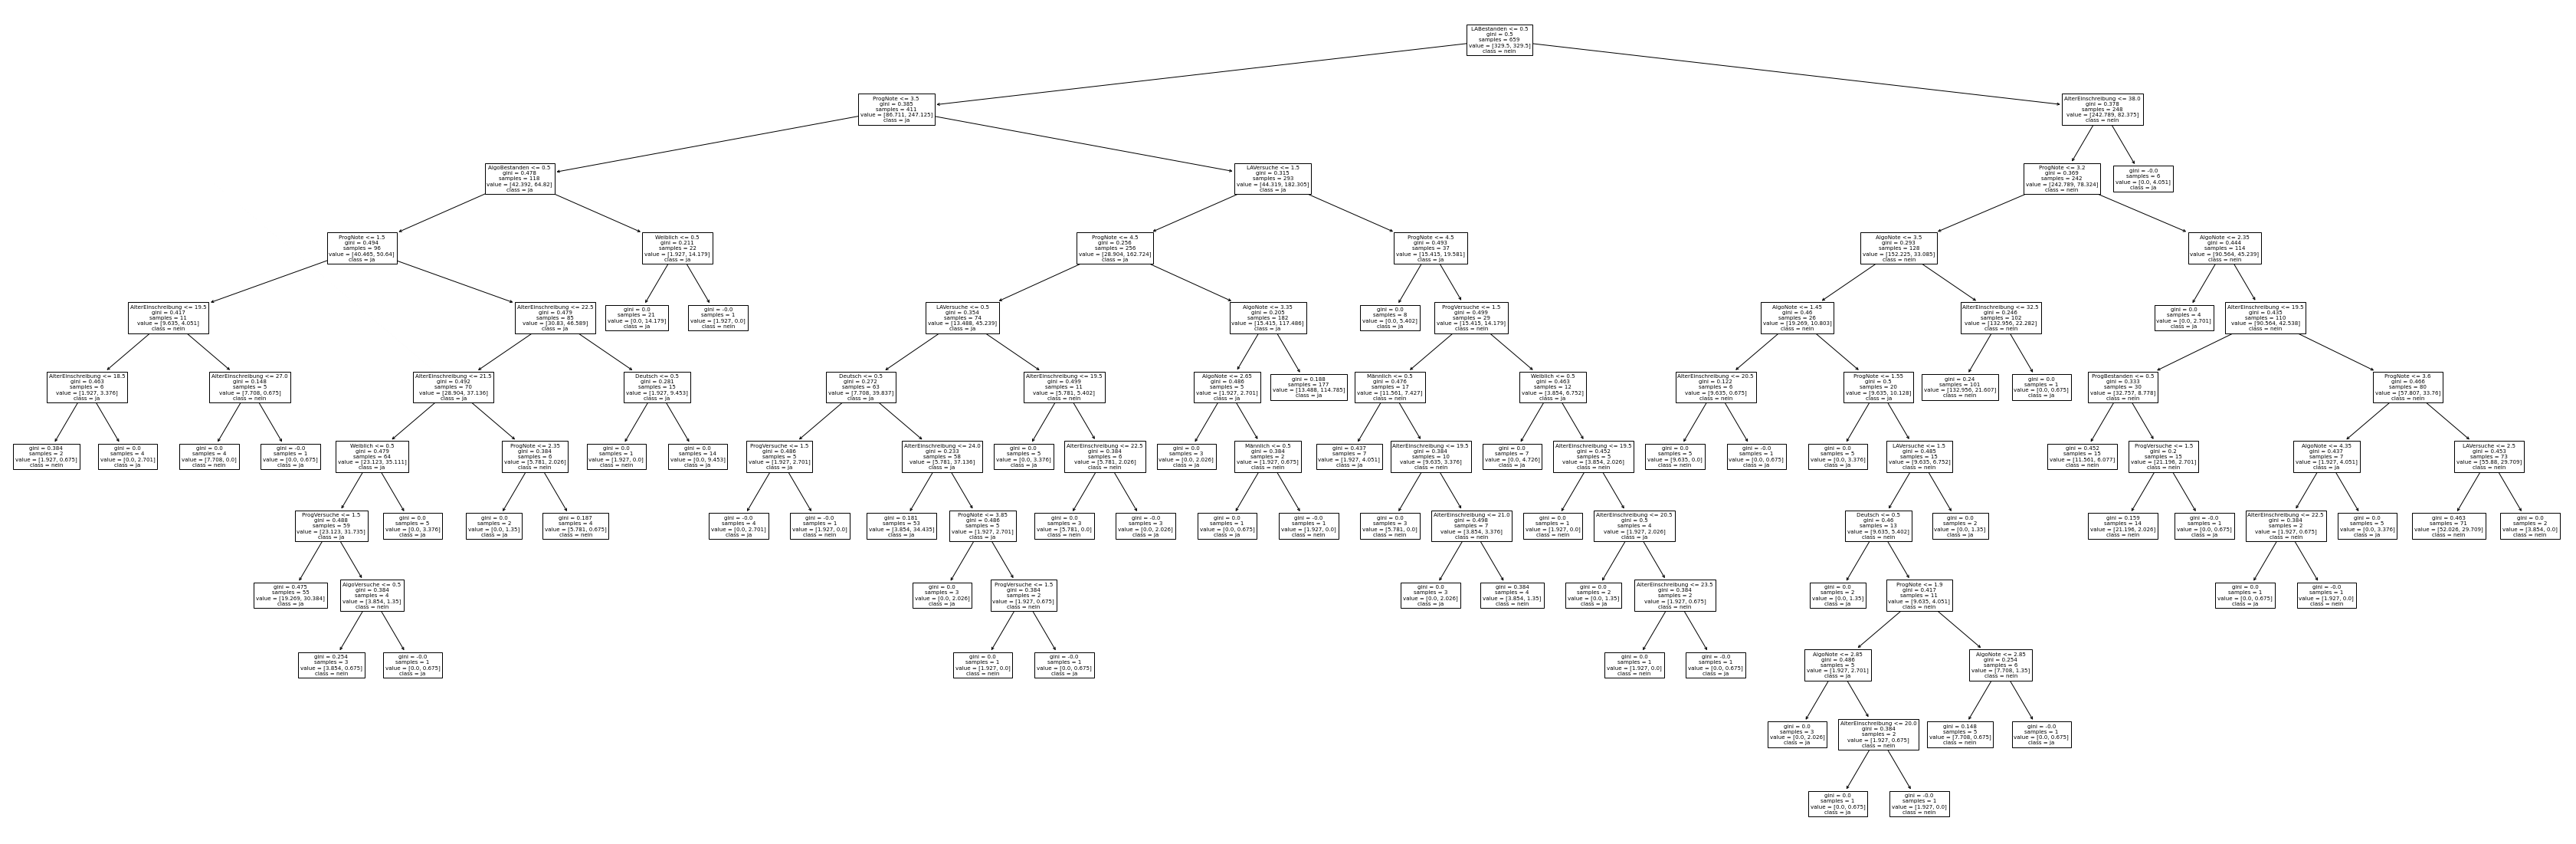

In [31]:
plot_tree(clf, feature_names = feature_names, class_names=["nein", "ja"])
plt.show()

### Post pruning

In [32]:
path = clf.cost_complexity_pruning_path(X_train, y_train)
path

{'ccp_alphas': array([0.        , 0.00129122, 0.00134318, 0.00147565, 0.00150971,
        0.00151745, 0.00151745, 0.00151745, 0.00151745, 0.00157231,
        0.00160323, 0.00160428, 0.00165483, 0.00174532, 0.00176085,
        0.00188413, 0.00191498, 0.00214868, 0.00220556, 0.00220946,
        0.00224212, 0.00233056, 0.00259084, 0.00293682, 0.00304838,
        0.0033829 , 0.00342625, 0.00371929, 0.00376129, 0.00383299,
        0.00476136, 0.00568342, 0.00694112, 0.00753475, 0.00882141,
        0.11852814]),
 'impurities': array([0.22841156, 0.22970278, 0.23373233, 0.23520798, 0.23671769,
        0.23823514, 0.23975259, 0.24127004, 0.24278749, 0.24593211,
        0.24753535, 0.25074391, 0.25405357, 0.25754421, 0.26458759,
        0.26647172, 0.26838669, 0.27483273, 0.27703829, 0.2814572 ,
        0.28818355, 0.29284468, 0.29802635, 0.30096317, 0.30401155,
        0.31754314, 0.32782188, 0.33154116, 0.33530246, 0.34296844,
        0.35249116, 0.35817458, 0.3651157 , 0.37265046, 0.38147186

Text(0, 0.5, 'Balanced Accuracy scores')

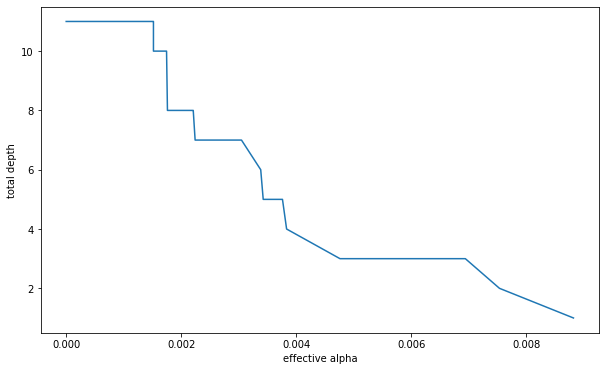

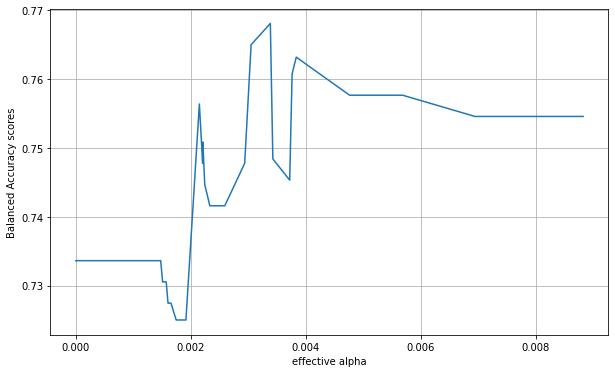

In [33]:
ccp_alphas, impurities = path.ccp_alphas, path.impurities

clfs = []

for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha,
                                 class_weight="balanced", min_impurity_decrease=0.001)
    clf.fit(X_train, y_train)
    clfs.append(clf)

tree_depths = [clf.tree_.max_depth for clf in clfs]
plt.figure(figsize=(10,  6))
plt.plot(ccp_alphas[:-1], tree_depths[:-1])
plt.xlabel("effective alpha")
plt.ylabel("total depth")


acc_scores = [balanced_accuracy_score(y_test, clf.predict(X_test)) for clf in clfs]

plt.figure(figsize=(10,  6))
plt.grid()
plt.plot(ccp_alphas[:-1], acc_scores[:-1])
plt.xlabel("effective alpha")
plt.ylabel("Balanced Accuracy scores")

# Trainset
Balanced accuracy: 0.7524925702233727
Area under curve: 0.7524925702233727
Confusion Matrix (tn, fp, fn, tp):
[[127  44]
 [116 372]]
# Testset
Balanced accuracy: 0.7631971051511282
Area under curve: 0.7631971051511282
Confusion Matrix (tn, fp, fn, tp):
[[ 47  11]
 [ 46 116]]


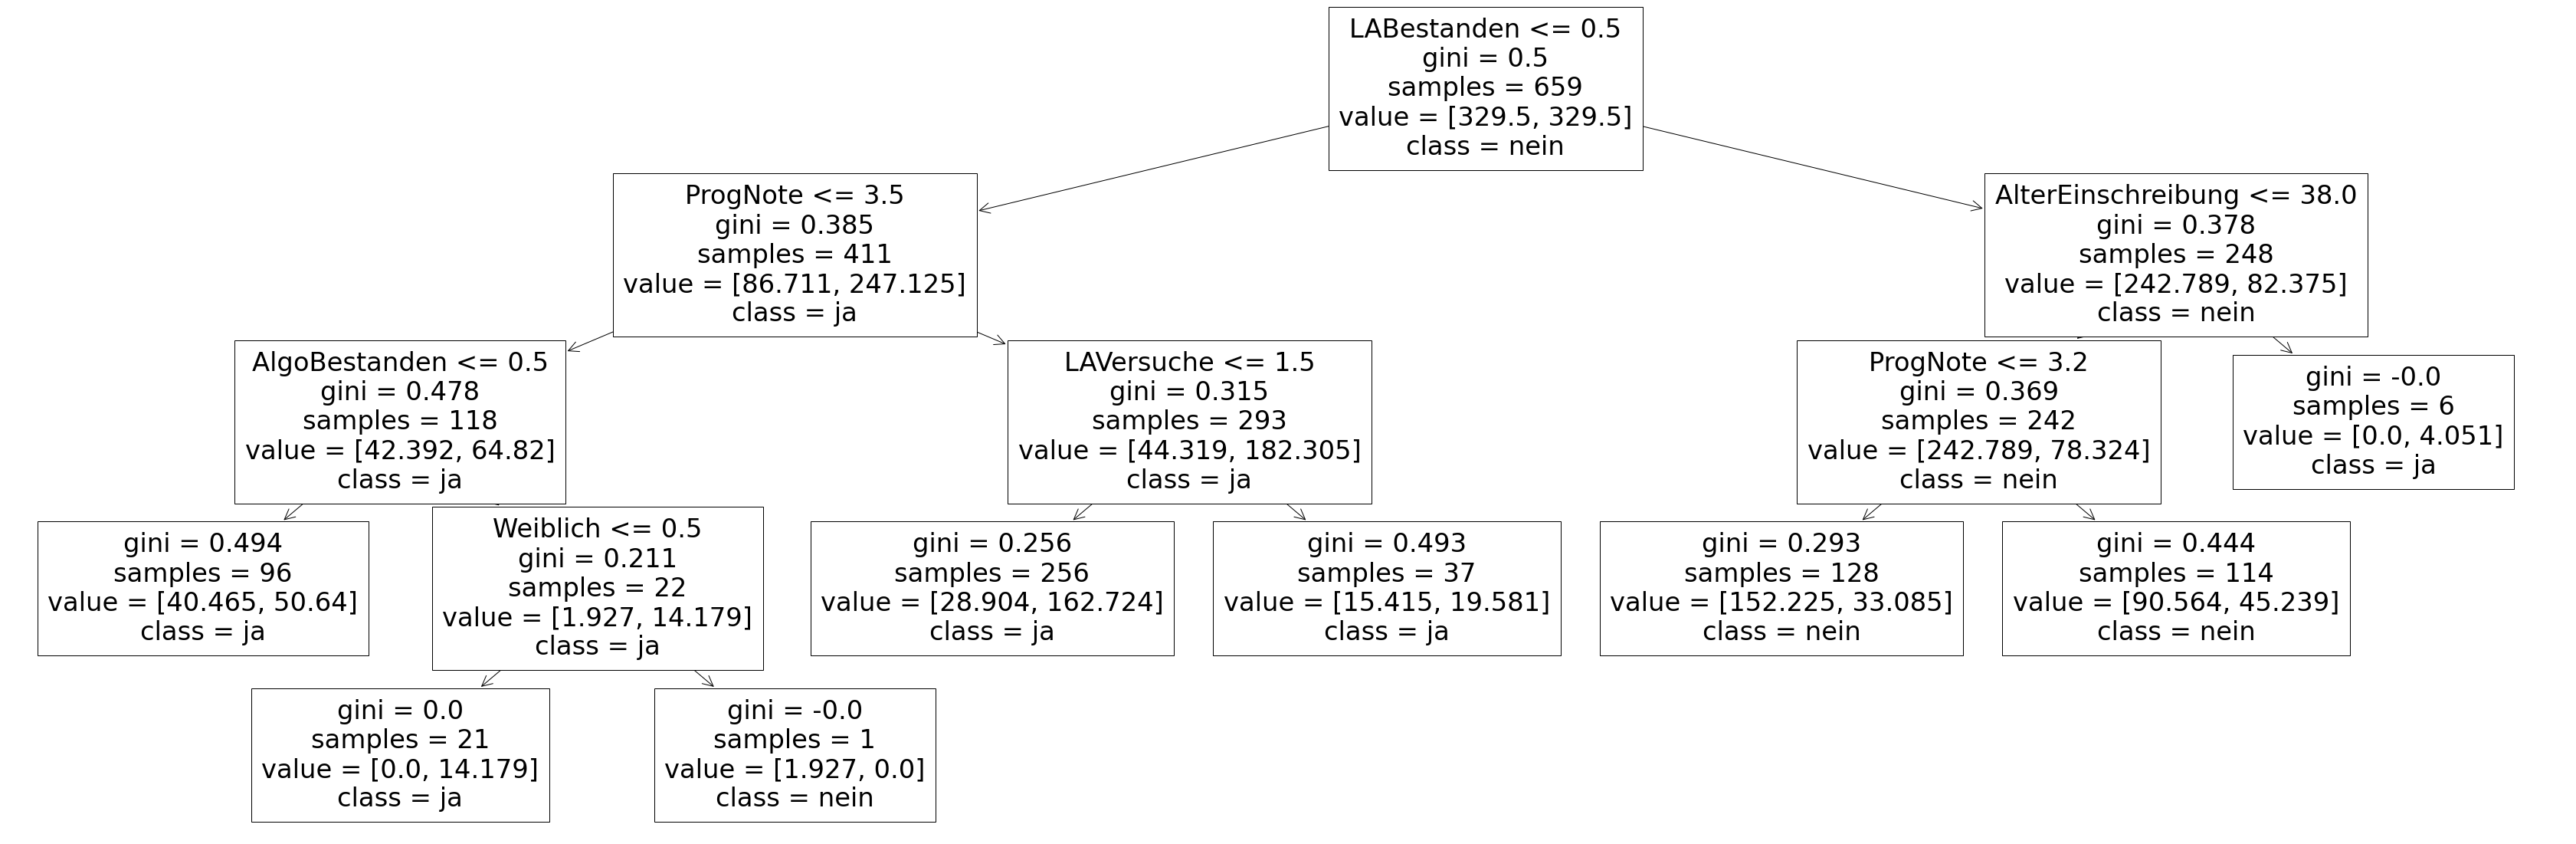

In [34]:
selected_ccp = 0.004
# selected_ccp = 0.0035

clf = DecisionTreeClassifier(random_state=0, class_weight="balanced", min_impurity_decrease=0.001,
                             ccp_alpha=selected_ccp)
clf.fit(X_train, y_train)

eval_model(clf, X_train, y_train, X_test, y_test)
plot_tree(clf, feature_names = feature_names, class_names=["nein", "ja"])
plt.show()

# Trainset
Balanced accuracy: 0.743421052631579
Area under curve: 0.7434210526315791
Confusion Matrix (tn, fp, fn, tp):
[[126  45]
 [122 366]]
# Testset
Balanced accuracy: 0.7545764154959558
Area under curve: 0.7545764154959558
Confusion Matrix (tn, fp, fn, tp):
[[ 46  12]
 [ 46 116]]


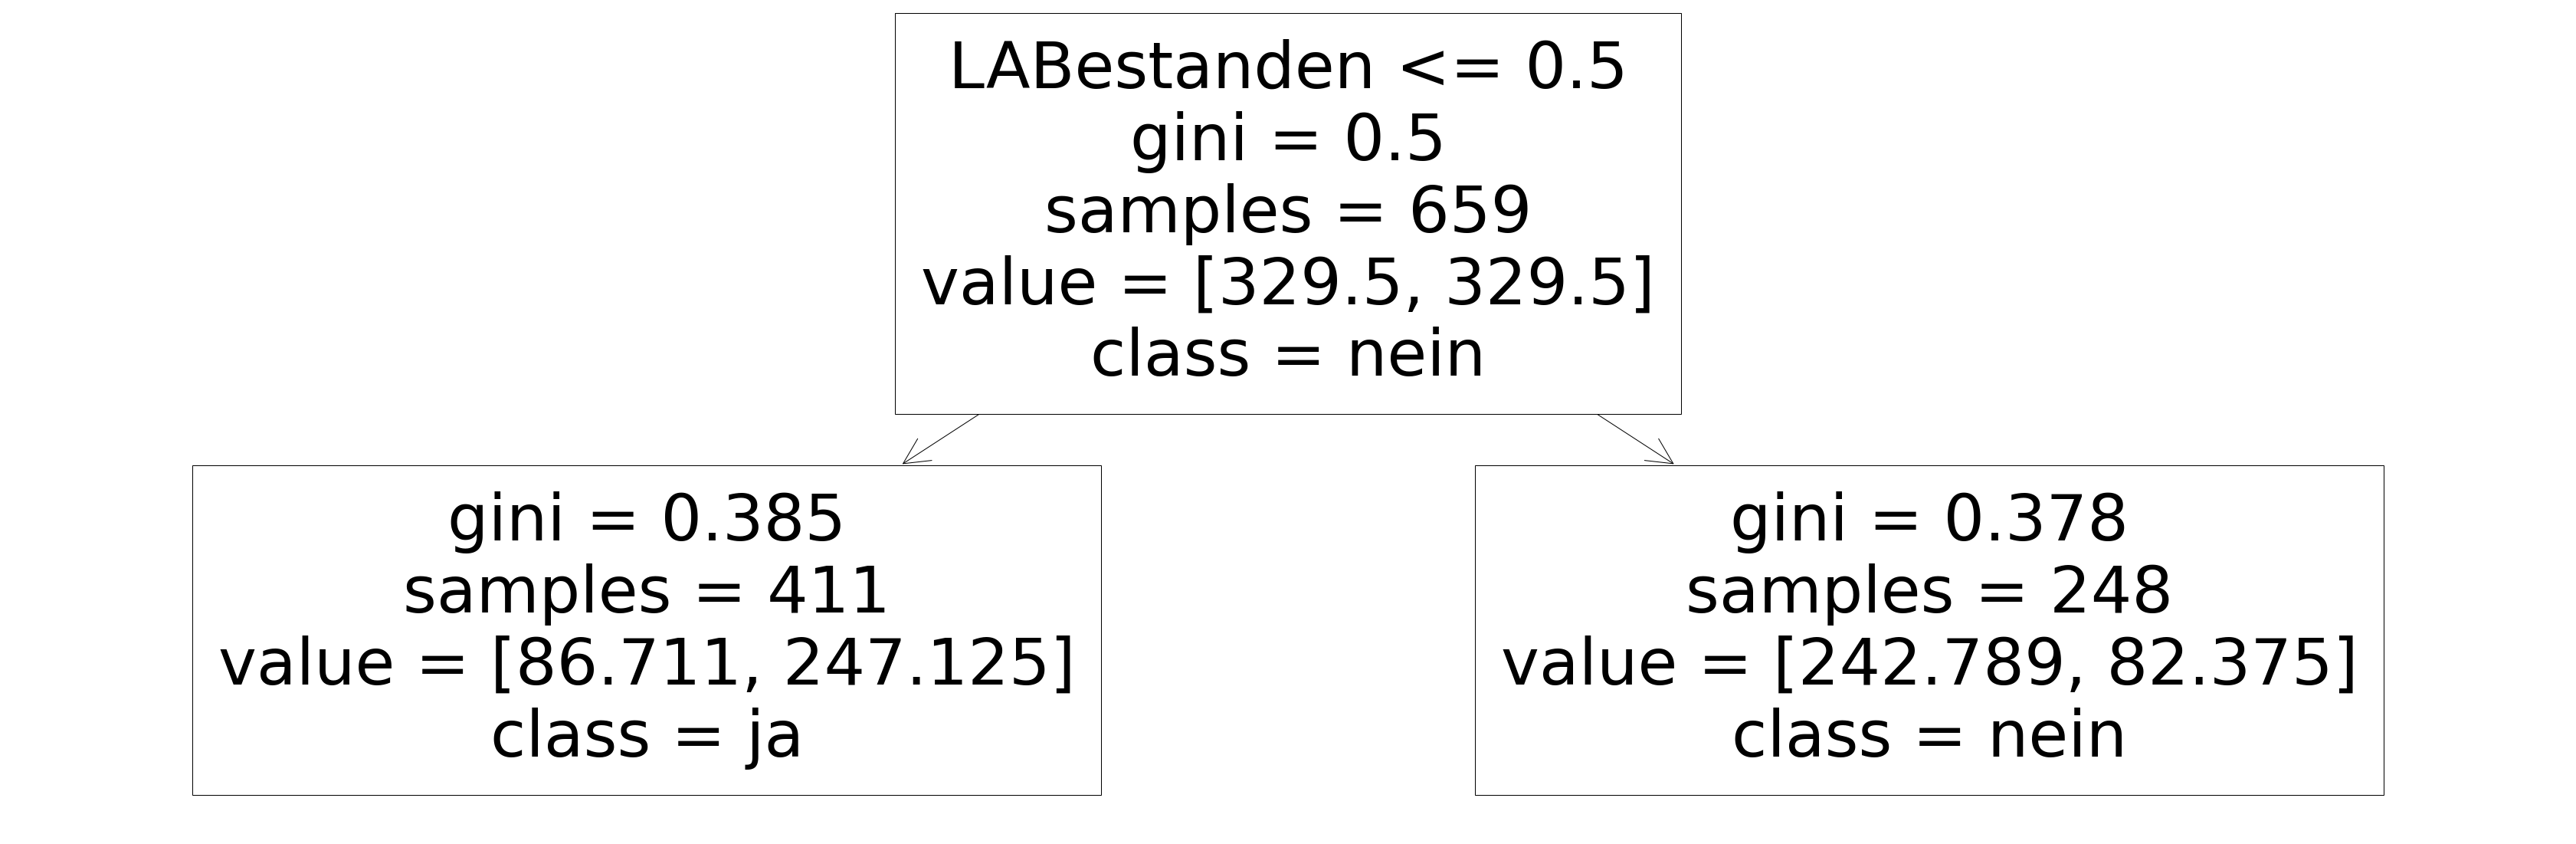

In [35]:
selected_ccp = 0.01

clf = DecisionTreeClassifier(random_state=0, class_weight="balanced", min_impurity_decrease=0.001,
                             ccp_alpha=selected_ccp)
clf.fit(X_train, y_train)

eval_model(clf, X_train, y_train, X_test, y_test)
plot_tree(clf, feature_names = feature_names, class_names=["nein", "ja"])
plt.show()


### Dropping Algorithms and Data Structures

As Algorithms and Data Structures is a third semester module for the majority of students in the data base (only changed recently to a first-semester course), we could interpret some correlations regarding the third semester. However, due to our constraint that each performance measure needs to be from the first semester, we circumvent the problem. As we see above, AlDat is not part of the resulting tree.

## Using old PO study order

Instead of using Algorithms and Datastructures, we can make use of Analysis I instead again.
While there are arguments against this (mainly PO'18), we were told that most students where advised to actually obey the old order with Analysis I in first semester and Algo in third semester again. This actually opens up the possibility to use the historical data for this.

In [36]:
sql = "sql/cs_first_three_module_old_dropout.sql"
df = data.query_sql_file(sql, data.db_conn)

df


,Geburtsjahr,Geschlecht,Deutsch,AlterEinschreibung,LABestanden,LAVersuche,ProgBestanden,ProgVersuche,ProgNote,AnaBestanden,AnaVersuche,Dropout
0,1972,männlich,1,35,1,1,0,0,5.0,0,0,0
1,1987,weiblich,1,20,1,1,1,1,3.7,1,1,0
2,1988,männlich,1,19,1,2,1,1,3.3,0,0,0
3,1989,weiblich,1,18,1,1,0,0,5.0,1,1,1
4,1987,weiblich,0,20,1,1,1,1,4.0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
893,1995,männlich,1,23,0,0,0,1,5.0,0,0,1
894,1990,männlich,1,28,0,0,0,1,5.0,1,1,1
895,1989,männlich,1,30,0,0,1,1,1.7,0,0,1
896,1993,männlich,1,26,1,1,0,0,5.0,1,1,1


In [37]:
print_metric(["Dropout", "LABestanden", "ProgBestanden", "AnaBestanden"], df)

Dropout: 667 (74.2761692650334 %)
LABestanden: 340 (37.8619153674833 %)
ProgBestanden: 497 (55.34521158129176 %)
AnaBestanden: 282 (31.403118040089087 %)


In [38]:
# Preprocess data
df_classification = df.copy(deep=True)
df_classification["Männlich"] = 1*(df_classification["Geschlecht"] == "männlich")
df_classification["Weiblich"] = 1*(df_classification["Geschlecht"] == "weiblich")
df_classification["Divers"] = 1*(df_classification["Geschlecht"] == "divers")

df_classification = df_classification.drop(["Geschlecht", "Geburtsjahr"], axis=1)
df_classification.head()


,Deutsch,AlterEinschreibung,LABestanden,LAVersuche,ProgBestanden,ProgVersuche,ProgNote,AnaBestanden,AnaVersuche,Dropout,Männlich,Weiblich,Divers
0,1,35,1,1,0,0,5.0,0,0,0,1,0,0
1,1,20,1,1,1,1,3.7,1,1,0,0,1,0
2,1,19,1,2,1,1,3.3,0,0,0,1,0,0
3,1,18,1,1,0,0,5.0,1,1,1,0,1,0
4,0,20,1,1,1,1,4.0,1,1,1,0,1,0


In [39]:
X = df_classification.drop(["Dropout"], axis=1)
y = df_classification["Dropout"]

feature_names = X.columns
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=12)


clf = DecisionTreeClassifier(random_state=0, class_weight="balanced", min_impurity_decrease=0.001)
clf.fit(X_train, y_train)
eval_model(clf, X_train, y_train, X_test, y_test)

# Trainset
Balanced accuracy: 0.8570200018224895
Area under curve: 0.8570200018224895
Confusion Matrix (tn, fp, fn, tp):
[[161  16]
 [ 97 399]]
# Testset
Balanced accuracy: 0.736842105263158
Area under curve: 0.736842105263158
Confusion Matrix (tn, fp, fn, tp):
[[ 42  12]
 [ 52 119]]


In [40]:
path = clf.cost_complexity_pruning_path(X_train, y_train)
path

{'ccp_alphas': array([0.        , 0.00104392, 0.00126762, 0.00145212, 0.00148588,
        0.00148588, 0.00149815, 0.00166315, 0.00168164, 0.00169483,
        0.00171086, 0.00171086, 0.00171086, 0.00171086, 0.00172739,
        0.00188393, 0.00192088, 0.00192459, 0.0019293 , 0.00204622,
        0.00228078, 0.00240261, 0.00241643, 0.00242814, 0.00256644,
        0.00282474, 0.00284078, 0.00355368, 0.00385043, 0.00488374,
        0.00504221, 0.00580353, 0.00674716, 0.00889505, 0.01172238,
        0.01522105, 0.1261683 ]),
 'impurities': array([0.20910306, 0.21014698, 0.2114146 , 0.21577097, 0.21725686,
        0.21874274, 0.22024089, 0.22190404, 0.22358569, 0.22528052,
        0.22699138, 0.22870225, 0.23041311, 0.23212397, 0.23385137,
        0.23761924, 0.241461  , 0.24531018, 0.24723948, 0.2492857 ,
        0.26068958, 0.26309219, 0.27034148, 0.28248216, 0.28761505,
        0.29043979, 0.29612136, 0.30678239, 0.31063282, 0.32040031,
        0.32544252, 0.33124605, 0.33799322, 0.34688826

Text(0, 0.5, 'Balanced Accuracy scores')

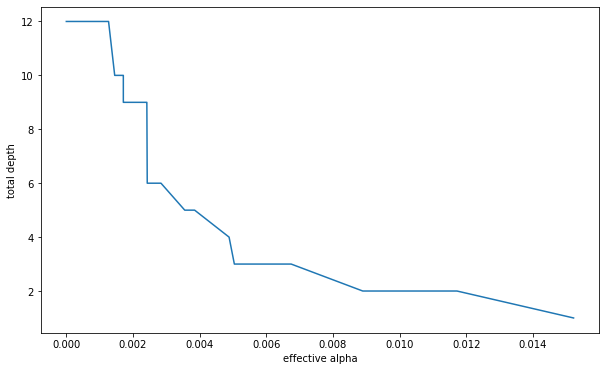

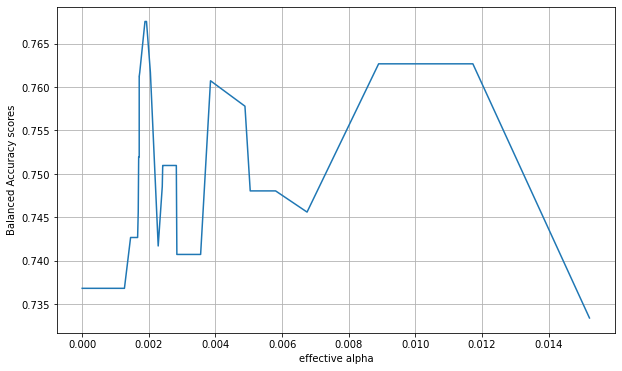

In [41]:
ccp_alphas, impurities = path.ccp_alphas, path.impurities

clfs = []

for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha,
                                 class_weight="balanced", min_impurity_decrease=0.001)
    clf.fit(X_train, y_train)
    clfs.append(clf)

tree_depths = [clf.tree_.max_depth for clf in clfs]
plt.figure(figsize=(10,  6))
plt.plot(ccp_alphas[:-1], tree_depths[:-1])
plt.xlabel("effective alpha")
plt.ylabel("total depth")


acc_scores = [balanced_accuracy_score(y_test, clf.predict(X_test)) for clf in clfs]

plt.figure(figsize=(10,  6))
plt.grid()
plt.plot(ccp_alphas[:-1], acc_scores[:-1])
plt.xlabel("effective alpha")
plt.ylabel("Balanced Accuracy scores")


# Trainset
Balanced accuracy: 0.7594029068707855
Area under curve: 0.7594029068707856
Confusion Matrix (tn, fp, fn, tp):
[[145  32]
 [149 347]]
# Testset
Balanced accuracy: 0.7626705653021442
Area under curve: 0.7626705653021443
Confusion Matrix (tn, fp, fn, tp):
[[ 47   7]
 [ 59 112]]


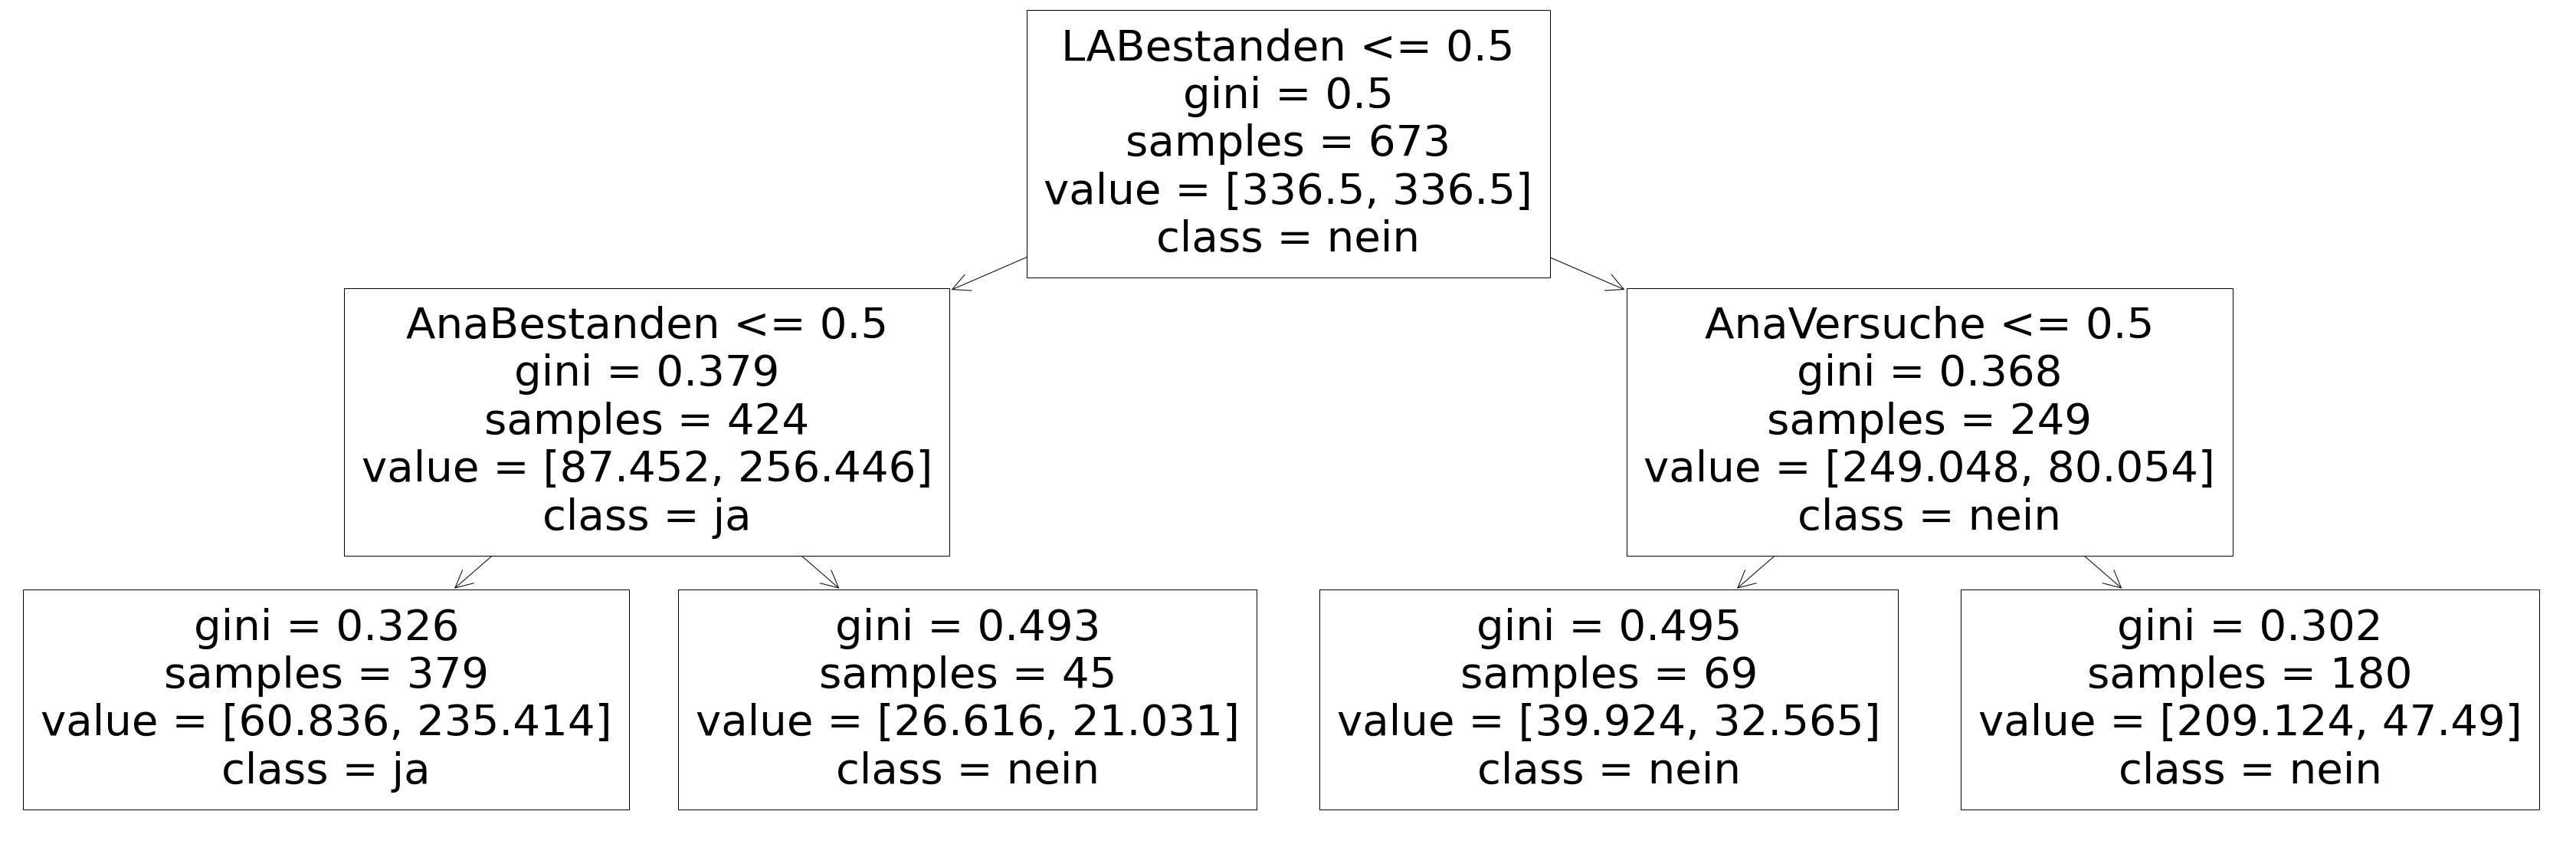

In [42]:
selected_ccp = 0.01

clf = DecisionTreeClassifier(random_state=0, class_weight="balanced", min_impurity_decrease=0.001,
                             ccp_alpha=selected_ccp)
clf.fit(X_train, y_train)

eval_model(clf, X_train, y_train, X_test, y_test)
plot_tree(clf, feature_names = feature_names, class_names=["nein", "ja"])
plt.show()



We see a difference in the classification model now: in case of failing LA, it still matters whether Ana was passed or not (although this seems to be a 50:50 call).

## Fairness Analysis

In [43]:
from rapp.fairness import clf_group_fairness
from rapp.fairness import clf_predictive_equality
from rapp.fairness import clf_equality_of_opportunity


In [44]:
def print_fairness_template(name, fairness):
    for category, column in [("Sex", "Männlich"),
                             ("Race", "Deutsch")]:
        print(f"{name}, {category}:", fairness[column]["disparity"],
              f"({fairness[column][1]['favourable_outcome']}/{fairness[column][1]['favourable_outcome']+fairness[column][1]['unfavourable_outcome']}",
              "vs.",
              f"{fairness[column][0]['favourable_outcome']}/{fairness[column][0]['favourable_outcome']+fairness[column][0]['unfavourable_outcome']})",
              )


def print_fairness(clf):
    fairness = clf_group_fairness(clf, X_test, ["Männlich", "Deutsch"])
    print_fairness_template("Statistical Disparity", fairness)

    test = pd.concat([X_test, y_test], axis=1)
    fairness = clf_predictive_equality(clf, test, "Dropout", ["Männlich", "Deutsch"])
    print_fairness_template("Predictive Equality", fairness)

    fairness = clf_equality_of_opportunity(clf, test, "Dropout", ["Männlich", "Deutsch"])
    print_fairness_template("Equality of Opportunity", fairness)


In [45]:
print_fairness(clf)

Statistical Disparity, Sex: 0.15261514441842305 (102/183 vs. 17/42)
Statistical Disparity, Race: 0.19615663524292964 (109/197 vs. 10/28)
Predictive Equality, Sex: 0.03636363636363635 (6/44 vs. 1/10)
Predictive Equality, Race: 0.022222222222222227 (6/45 vs. 1/9)
Equality of Opportunity, Sex: -0.19064748201438847 (96/139 vs. 16/32)
Equality of Opportunity, Race: -0.2039473684210526 (103/152 vs. 9/19)


We see severe unfairness versus both, females and foreigners.

### Sex discrimination

In [46]:
X_train_priv = X_train[X_train["Männlich"] == 1]
y_train_priv = y_train[X_train["Männlich"] == 1]
X_test_priv = X_test[X_test["Männlich"] == 1]
y_test_priv = y_test[X_test["Männlich"] == 1]

X_train_unpriv = X_train[X_train["Männlich"] == 0]
y_train_unpriv = y_train[X_train["Männlich"] == 0]
X_test_unpriv = X_test[X_test["Männlich"] == 0]
y_test_unpriv = y_test[X_test["Männlich"] == 0]


In [47]:
clf_priv = DecisionTreeClassifier(class_weight="balanced", min_impurity_decrease=0.001)
clf_priv.fit(X_train_priv, y_train_priv)

clf_unpriv = DecisionTreeClassifier(class_weight="balanced", min_impurity_decrease=0.001)
clf_unpriv.fit(X_train_unpriv, y_train_unpriv)


DecisionTreeClassifier(class_weight='balanced', min_impurity_decrease=0.001)

#### Privileged Group: Males

# Trainset
Balanced accuracy: 0.9076106513134221
Area under curve: 0.9076106513134221
Confusion Matrix (tn, fp, fn, tp):
[[130  10]
 [ 45 352]]
# Testset
Balanced accuracy: 0.6623610202746893
Area under curve: 0.6623610202746892
Confusion Matrix (tn, fp, fn, tp):
[[ 26  18]
 [ 37 102]]


Text(0, 0.5, 'Balanced Accuracy scores')

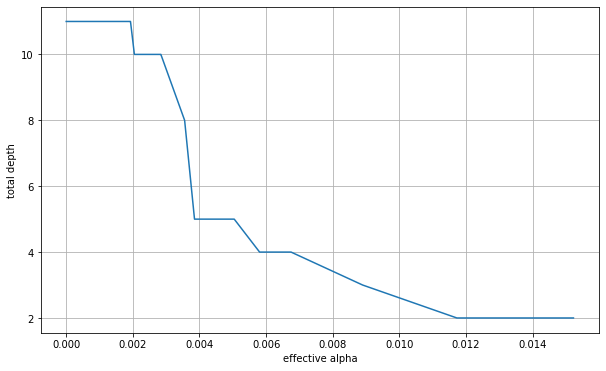

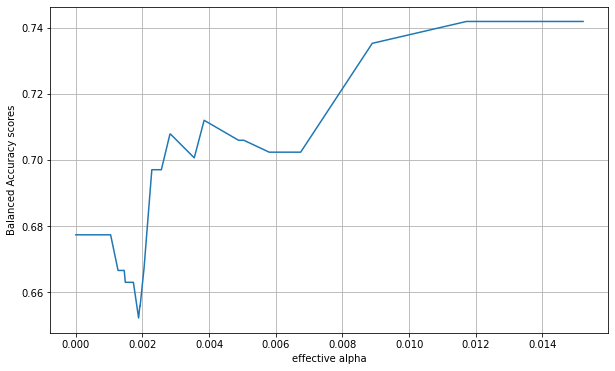

In [48]:
eval_model(clf_priv, X_train_priv, y_train_priv, X_test_priv, y_test_priv)

ccp_alphas, impurities = path.ccp_alphas, path.impurities

clfs = []

for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha,
                                 class_weight="balanced", min_impurity_decrease=0.001)
    clf.fit(X_train_priv, y_train_priv)
    clfs.append(clf)

tree_depths = [clf.tree_.max_depth for clf in clfs]
plt.figure(figsize=(10,  6))
plt.grid()
plt.plot(ccp_alphas[:-1], tree_depths[:-1])
plt.xlabel("effective alpha")
plt.ylabel("total depth")


acc_scores = [balanced_accuracy_score(y_test_priv, clf.predict(X_test_priv)) for clf in clfs]

plt.figure(figsize=(10,  6))
plt.grid()
plt.plot(ccp_alphas[:-1], acc_scores[:-1])
plt.xlabel("effective alpha")
plt.ylabel("Balanced Accuracy scores")


# Trainset
Balanced accuracy: 0.7534544800287873
Area under curve: 0.7534544800287875
Confusion Matrix (tn, fp, fn, tp):
[[102  38]
 [ 88 309]]
# Testset
Balanced accuracy: 0.7419064748201438
Area under curve: 0.7419064748201438
Confusion Matrix (tn, fp, fn, tp):
[[ 33  11]
 [ 37 102]]


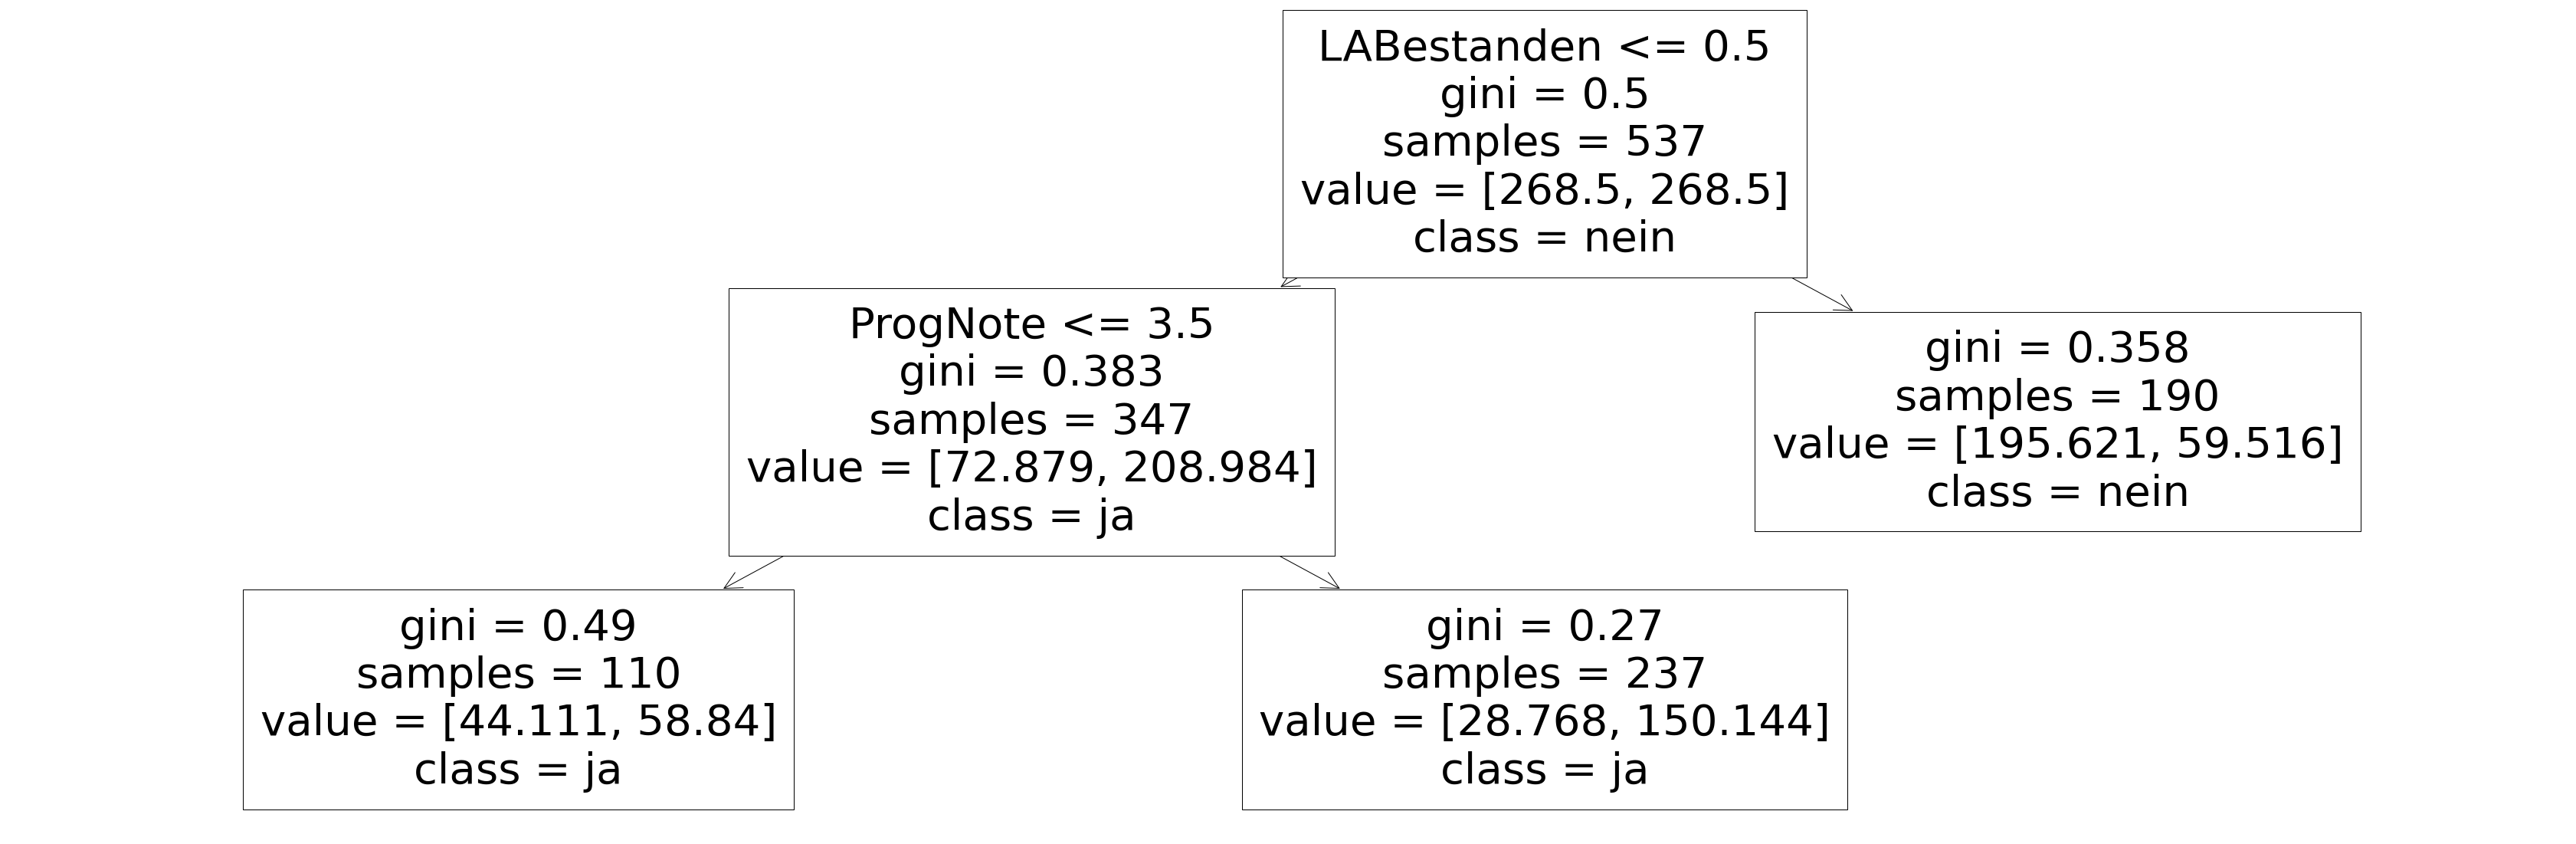

In [49]:
selected_ccp = 0.011
# selected_ccp = 0.00733871

clf = DecisionTreeClassifier(random_state=0, class_weight="balanced", min_impurity_decrease=0.001,
                             ccp_alpha=selected_ccp)
clf.fit(X_train_priv, y_train_priv)

eval_model(clf, X_train_priv, y_train_priv, X_test_priv, y_test_priv)
plot_tree(clf, feature_names = feature_names, class_names=["nein", "ja"])
plt.show()

clf_priv = clf


#### Unprivileged Group: Females

# Trainset
Balanced accuracy: 0.994949494949495
Area under curve: 0.994949494949495
Confusion Matrix (tn, fp, fn, tp):
[[37  0]
 [ 1 98]]
# Testset
Balanced accuracy: 0.740625
Area under curve: 0.740625
Confusion Matrix (tn, fp, fn, tp):
[[ 7  3]
 [ 7 25]]


Text(0, 0.5, 'Balanced Accuracy scores')

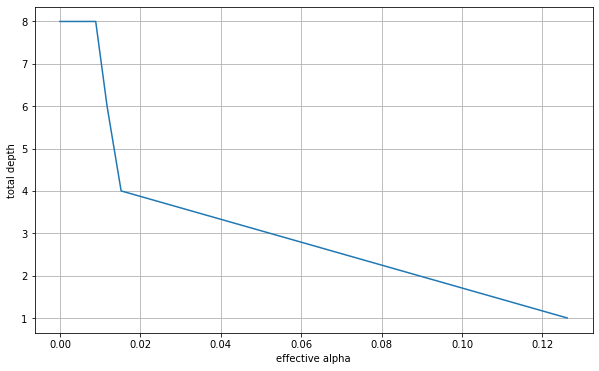

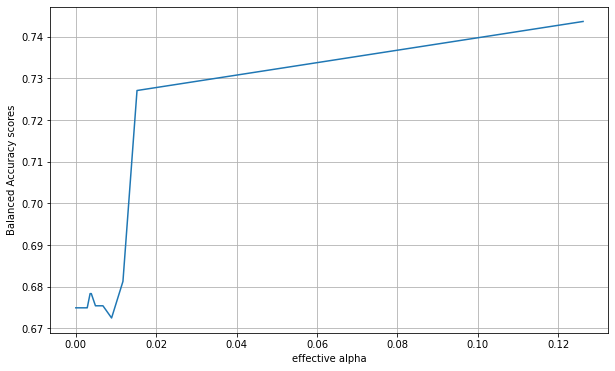

In [50]:
eval_model(clf_unpriv, X_train_unpriv, y_train_unpriv, X_test_unpriv, y_test_unpriv)

ccp_alphas, impurities = path.ccp_alphas, path.impurities

clfs = []

for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha,
                                 class_weight="balanced", min_impurity_decrease=0.001)
    clf.fit(X_train_unpriv, y_train_unpriv)
    clfs.append(clf)

tree_depths = [clf.tree_.max_depth for clf in clfs]
plt.figure(figsize=(10,  6))
plt.grid()
plt.plot(ccp_alphas, tree_depths)
plt.xlabel("effective alpha")
plt.ylabel("total depth")


acc_scores = [balanced_accuracy_score(y_test, clf.predict(X_test)) for clf in clfs]

plt.figure(figsize=(10,  6))
plt.grid()
plt.plot(ccp_alphas, acc_scores)
plt.xlabel("effective alpha")
plt.ylabel("Balanced Accuracy scores")

# Trainset
Balanced accuracy: 0.7553917553917554
Area under curve: 0.7553917553917553
Confusion Matrix (tn, fp, fn, tp):
[[26 11]
 [19 80]]
# Testset
Balanced accuracy: 0.74375
Area under curve: 0.74375
Confusion Matrix (tn, fp, fn, tp):
[[ 8  2]
 [10 22]]


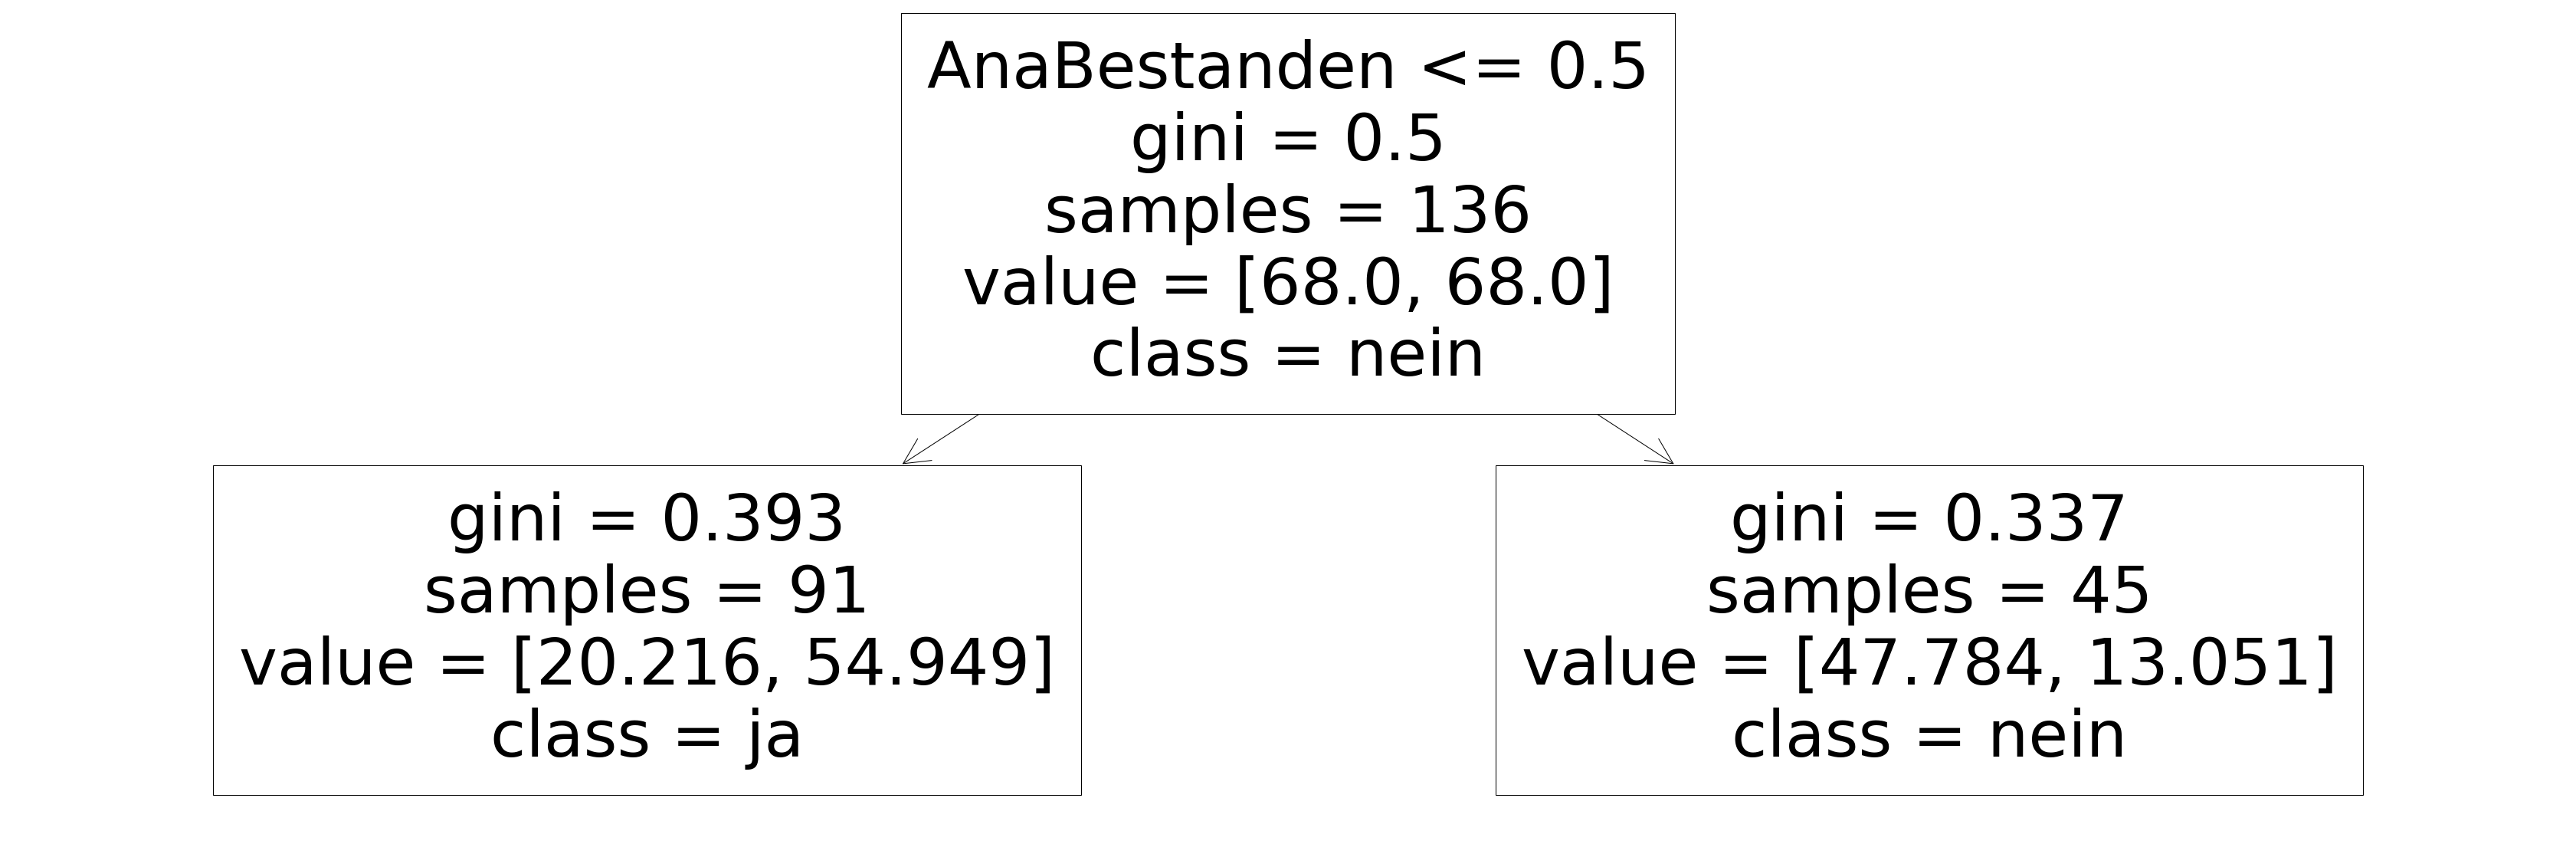

In [51]:
for selected_ccp in [0.13]:
    clf = DecisionTreeClassifier(random_state=0, class_weight="balanced", min_impurity_decrease=0.001,
                                ccp_alpha=selected_ccp)
    clf.fit(X_train_unpriv, y_train_unpriv)

    eval_model(clf, X_train_unpriv, y_train_unpriv, X_test_unpriv, y_test_unpriv)
    plot_tree(clf, feature_names = feature_names, class_names=["nein", "ja"])
    plt.show()

    clf_unpriv = clf


We see, interestingly, that females have Analysis I as actually the strongest predictor for dropout, while males have Linear Algebra.

### Race discrimination

In [52]:
X_train_priv = X_train[X_train["Deutsch"] == 1]
y_train_priv = y_train[X_train["Deutsch"] == 1]
X_test_priv = X_test[X_test["Deutsch"] == 1]
y_test_priv = y_test[X_test["Deutsch"] == 1]

X_train_unpriv = X_train[X_train["Deutsch"] == 0]
y_train_unpriv = y_train[X_train["Deutsch"] == 0]
X_test_unpriv = X_test[X_test["Deutsch"] == 0]
y_test_unpriv = y_test[X_test["Deutsch"] == 0]

clf_priv = DecisionTreeClassifier(class_weight="balanced", min_impurity_decrease=0.001)
clf_priv.fit(X_train_priv, y_train_priv)

clf_unpriv = DecisionTreeClassifier(class_weight="balanced", min_impurity_decrease=0.001)
clf_unpriv.fit(X_train_unpriv, y_train_unpriv)



DecisionTreeClassifier(class_weight='balanced', min_impurity_decrease=0.001)

#### Privileged Group: Germans


# Trainset
Balanced accuracy: 0.8960800326663945
Area under curve: 0.8960800326663945
Confusion Matrix (tn, fp, fn, tp):
[[143  15]
 [ 49 385]]
# Testset
Balanced accuracy: 0.7070906432748538
Area under curve: 0.7070906432748537
Confusion Matrix (tn, fp, fn, tp):
[[ 29  16]
 [ 35 117]]


Text(0, 0.5, 'Balanced Accuracy scores')

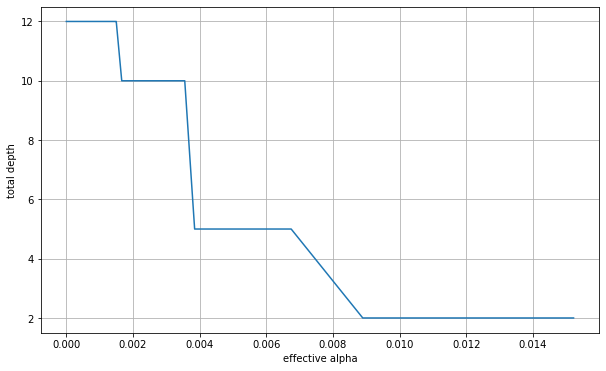

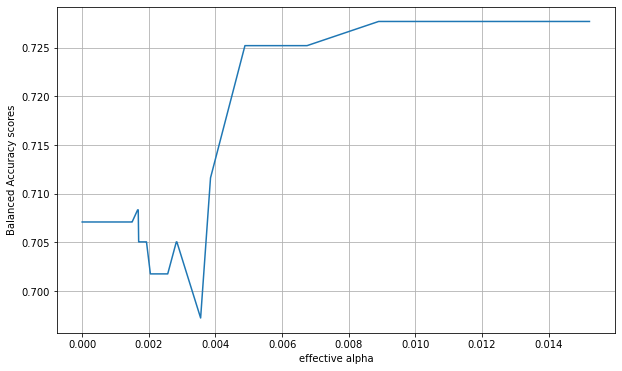

In [53]:
eval_model(clf_priv, X_train_priv, y_train_priv, X_test_priv, y_test_priv)

ccp_alphas, impurities = path.ccp_alphas, path.impurities

clfs = []

for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha,
                                 class_weight="balanced", min_impurity_decrease=0.001)
    clf.fit(X_train_priv, y_train_priv)
    clfs.append(clf)

tree_depths = [clf.tree_.max_depth for clf in clfs]
plt.figure(figsize=(10,  6))
plt.grid()
plt.plot(ccp_alphas[:-1], tree_depths[:-1])
plt.xlabel("effective alpha")
plt.ylabel("total depth")


acc_scores = [balanced_accuracy_score(y_test_priv, clf.predict(X_test_priv)) for clf in clfs]

plt.figure(figsize=(10,  6))
plt.grid()
plt.plot(ccp_alphas[:-1], acc_scores[:-1])
plt.xlabel("effective alpha")
plt.ylabel("Balanced Accuracy scores")


# Trainset
Balanced accuracy: 0.7768914425713119
Area under curve: 0.7768914425713118
Confusion Matrix (tn, fp, fn, tp):
[[129  29]
 [114 320]]
# Testset
Balanced accuracy: 0.7277046783625731
Area under curve: 0.7277046783625732
Confusion Matrix (tn, fp, fn, tp):
[[ 35  10]
 [ 49 103]]


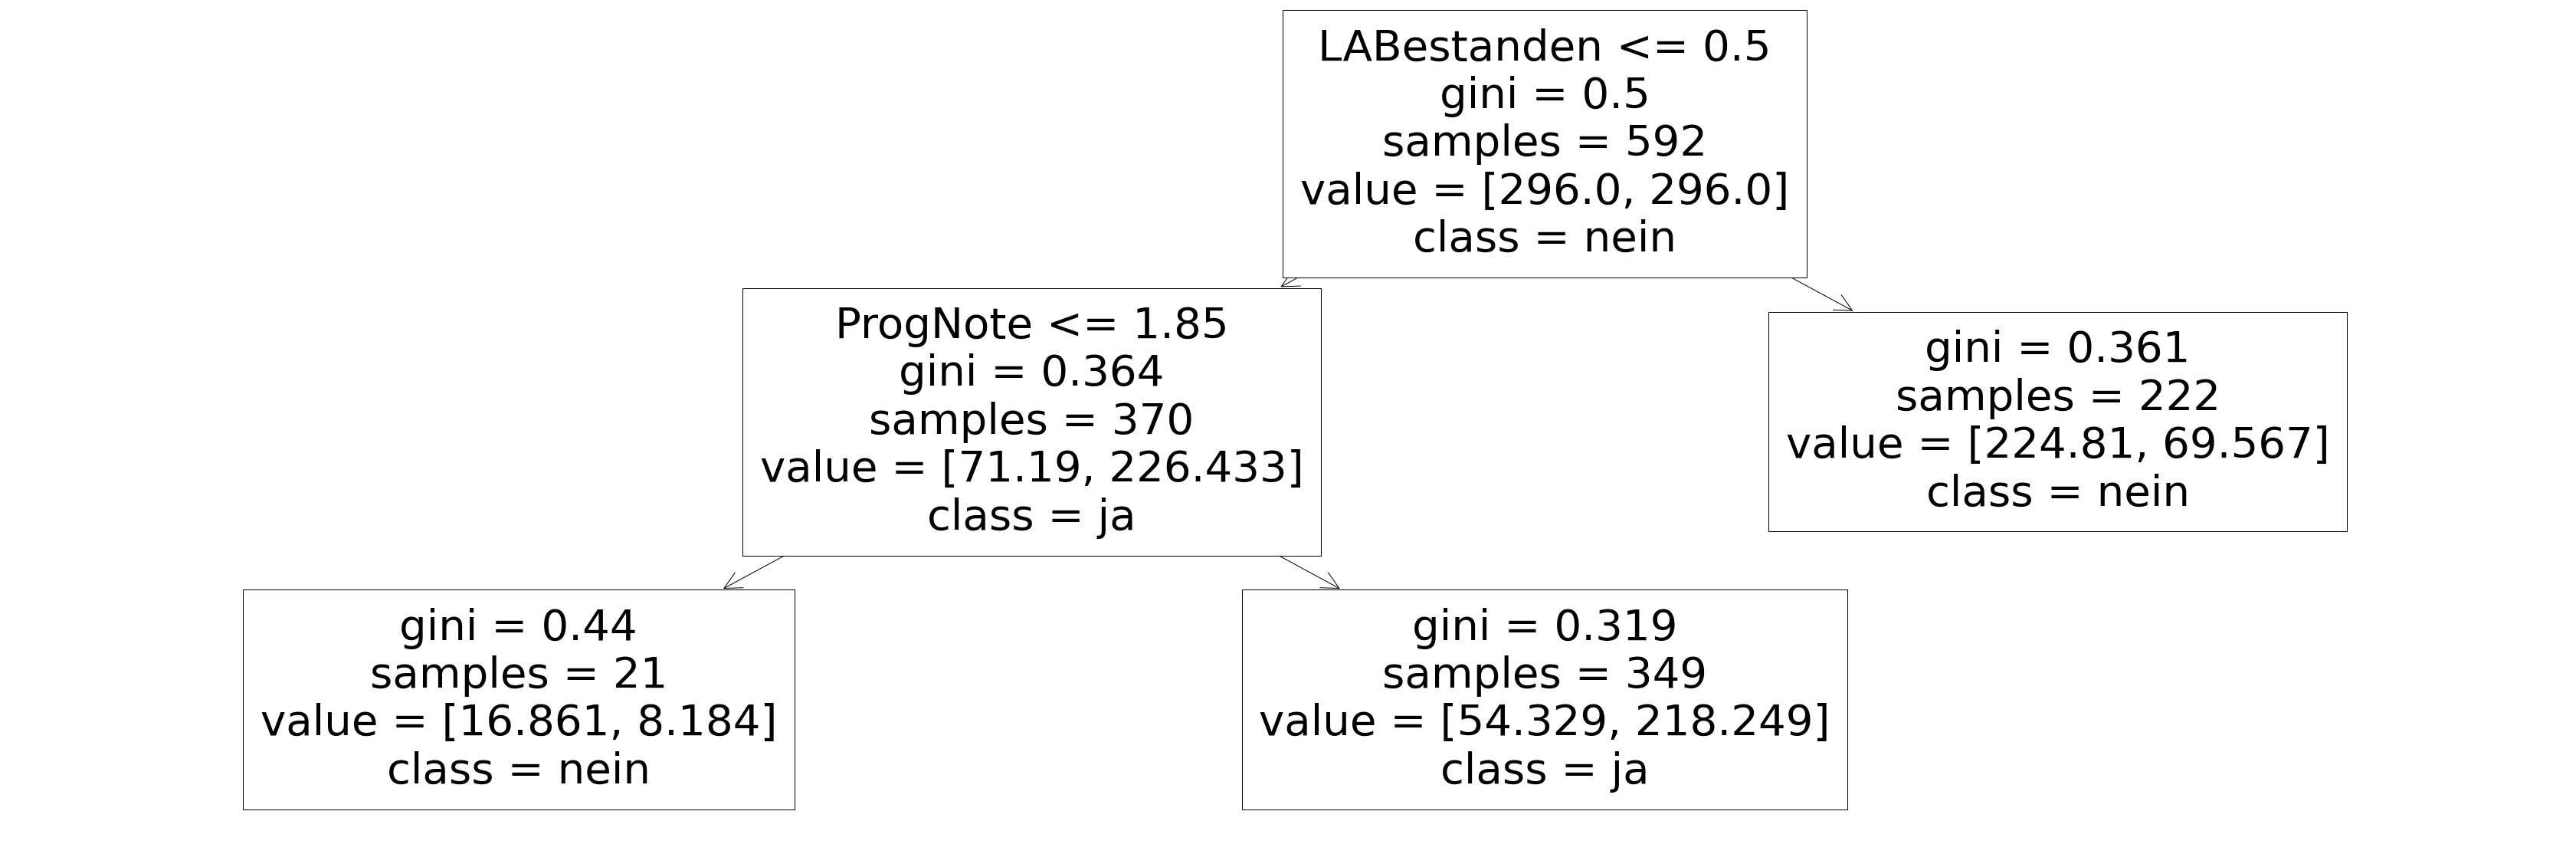

In [54]:
selected_ccp = 0.010

clf = DecisionTreeClassifier(random_state=0, class_weight="balanced", min_impurity_decrease=0.001,
                             ccp_alpha=selected_ccp)
clf.fit(X_train_priv, y_train_priv)

eval_model(clf, X_train_priv, y_train_priv, X_test_priv, y_test_priv)
plot_tree(clf, feature_names = feature_names, class_names=["nein", "ja"])
plt.show()

clf_priv = clf



#### Unprivileged Group: Foreign Students

# Trainset
Balanced accuracy: 0.9838709677419355
Area under curve: 0.9838709677419355
Confusion Matrix (tn, fp, fn, tp):
[[19  0]
 [ 2 60]]
# Testset
Balanced accuracy: 0.7017543859649122
Area under curve: 0.7017543859649125
Confusion Matrix (tn, fp, fn, tp):
[[ 6  3]
 [ 5 14]]


Text(0, 0.5, 'Balanced Accuracy scores')

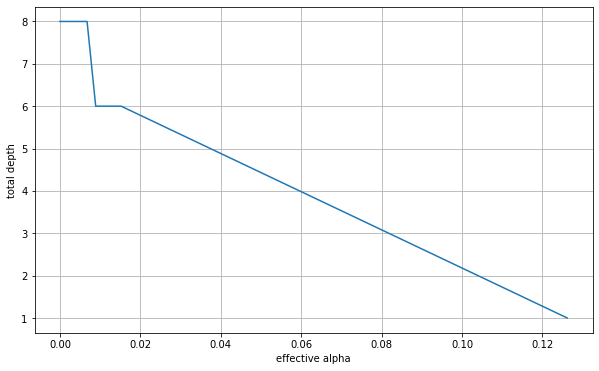

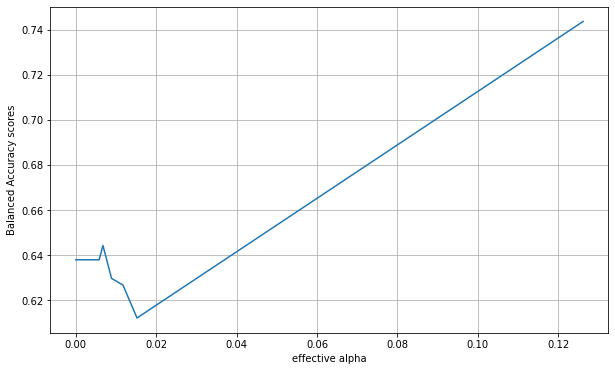

In [55]:
eval_model(clf_unpriv, X_train_unpriv, y_train_unpriv, X_test_unpriv, y_test_unpriv)

ccp_alphas, impurities = path.ccp_alphas, path.impurities

clfs = []

for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha,
                                 class_weight="balanced", min_impurity_decrease=0.001)
    clf.fit(X_train_unpriv, y_train_unpriv)
    clfs.append(clf)

tree_depths = [clf.tree_.max_depth for clf in clfs]
plt.figure(figsize=(10,  6))
plt.grid()
plt.plot(ccp_alphas, tree_depths)
plt.xlabel("effective alpha")
plt.ylabel("total depth")


acc_scores = [balanced_accuracy_score(y_test, clf.predict(X_test)) for clf in clfs]

plt.figure(figsize=(10,  6))
plt.grid()
plt.plot(ccp_alphas, acc_scores)
plt.xlabel("effective alpha")
plt.ylabel("Balanced Accuracy scores")


# Trainset
Balanced accuracy: 0.7555178268251272
Area under curve: 0.7555178268251274
Confusion Matrix (tn, fp, fn, tp):
[[14  5]
 [14 48]]
# Testset
Balanced accuracy: 0.7573099415204678
Area under curve: 0.7573099415204678
Confusion Matrix (tn, fp, fn, tp):
[[ 7  2]
 [ 5 14]]


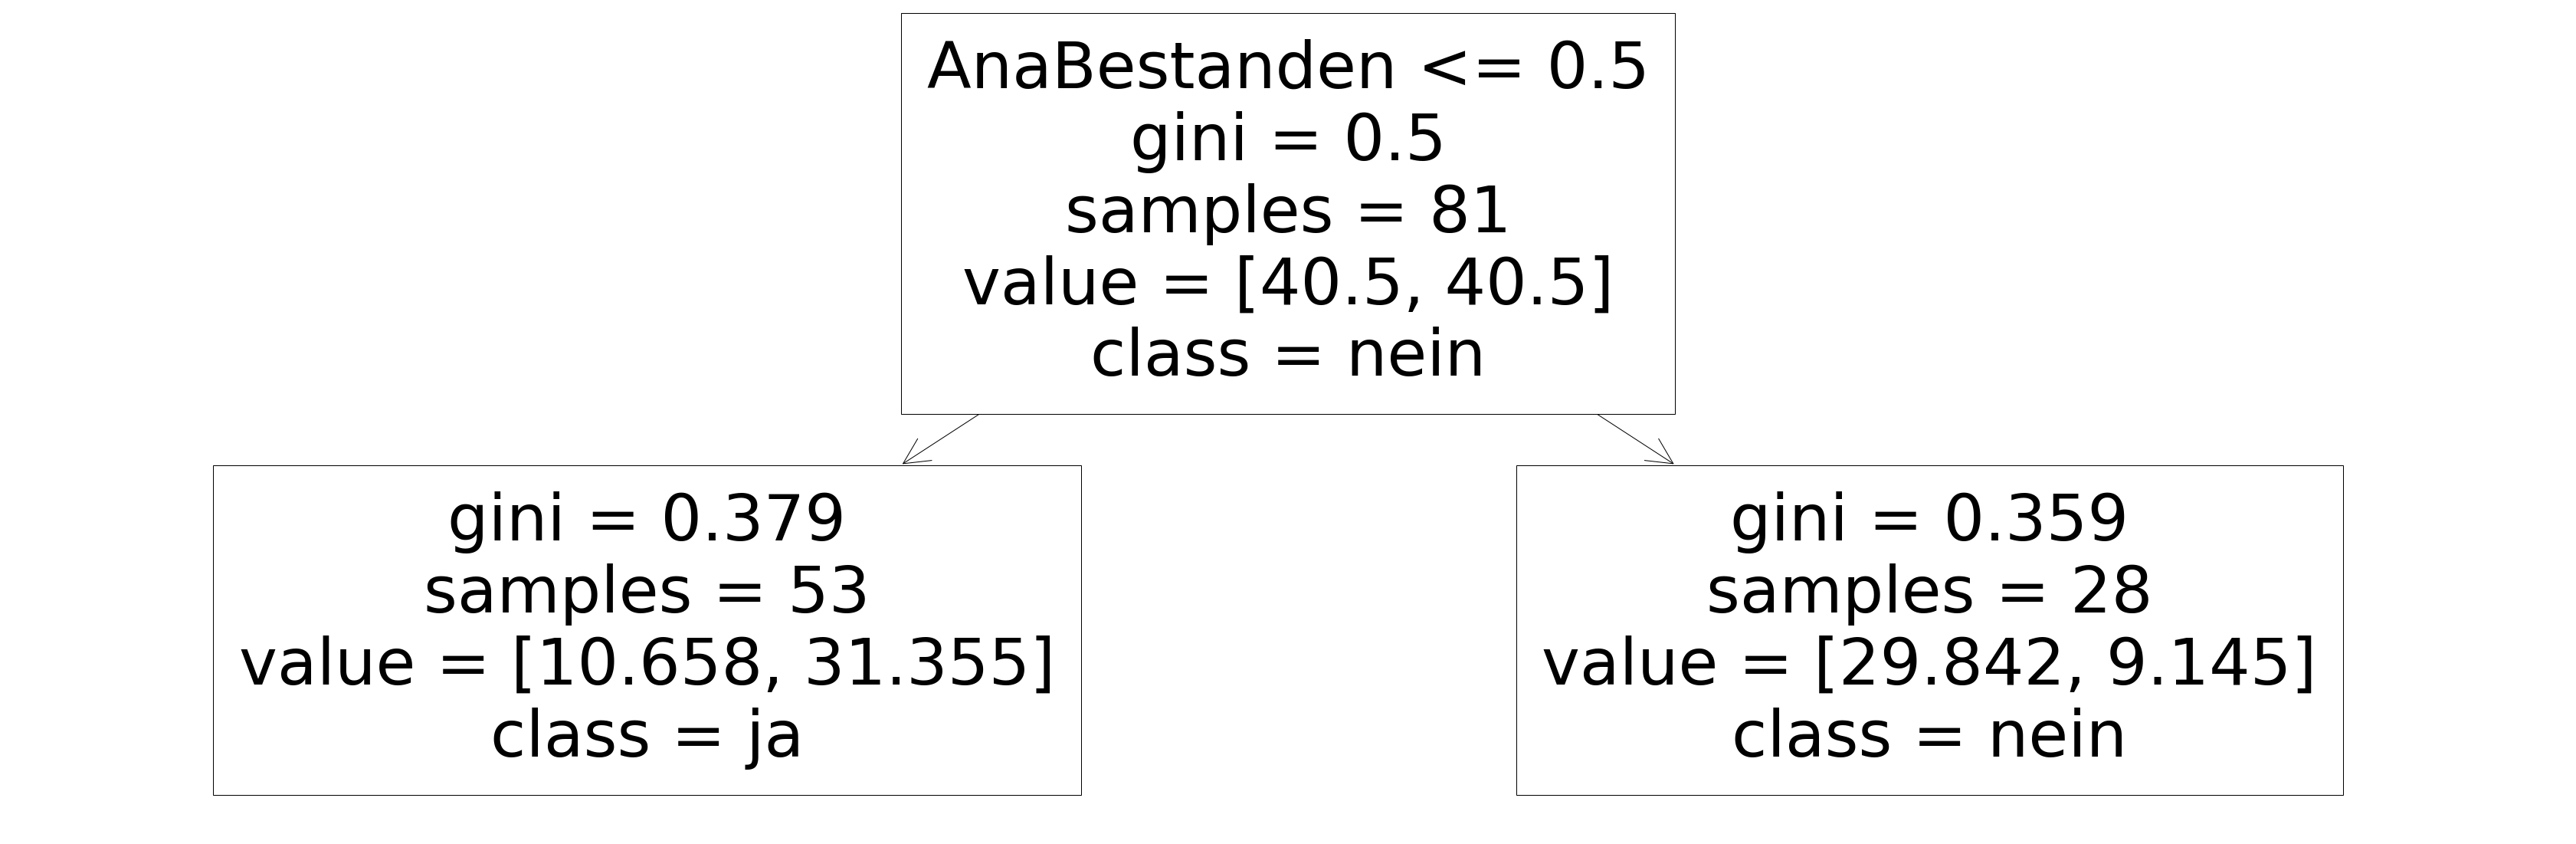

In [57]:
for selected_ccp in [0.13]:
    clf = DecisionTreeClassifier(random_state=0, class_weight="balanced", min_impurity_decrease=0.001,
                                ccp_alpha=selected_ccp)
    clf.fit(X_train_unpriv, y_train_unpriv)

    eval_model(clf, X_train_unpriv, y_train_unpriv, X_test_unpriv, y_test_unpriv)
    plot_tree(clf, feature_names = feature_names, class_names=["nein", "ja"])
    plt.show()

    clf_unpriv = clf



It seems as if specifically German males are struggling more with LA while females or foreign students struggle the most with Analysis.